In [40]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
print("""Please enter a dataset for evaluation\n
       0 - CAVIAR-o
       1 - TownCentre
       2 - IDIAP""")

dataset_id = int(input())

if dataset_id == 0:
    dataset_name = "CAVIAR-o"
    dataset_path = 'data/CAVIAR-o.pkl.gz'
    pretrained_path = 'pretrained_models/CAVIAR-o'
    net_output = 'pan'
elif dataset_id == 1:
    dataset_name = "TownCentre"
    dataset_path = 'data/TownCentre.pkl.gz'
    net_output = 'pan'
elif dataset_id == 2:
    dataset_name = "IDIAP"
    dataset_path = 'data//IDIAP.pkl'
    print("""Please enter desired net output
           0 - pan
           1 - tilt
           2 - roll""")
    net_output_id = int(input())
    if net_output_id == 0:
        net_output = 'pan'
    elif net_output_id == 1:
        net_output = 'tilt'
    elif net_output_id == 2:
        net_output = 'roll'
        
print("Working with %s dataset, net output: %s" % (dataset_name, net_output))

Please enter a dataset for evaluation

       0 - CAVIAR-o
       1 - TownCentre
       2 - IDIAP
1
Working with TownCentre dataset, net output: pan


In [42]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [46]:
pretrained_path = os.path.join('pretrained_models', dataset_name)

vggbit_cosine_config_path = os.path.join(pretrained_path, 'cosine/model.best.params.yml')
vggbit_cosine_weights_path = os.path.join(pretrained_path, 'cosine/model.best.weights.hdf5')
vggbit_likelihood_config_path = os.path.join(pretrained_path, 'likelihood/model.best.params.yml')
vggbit_likelihood_weights_path =  os.path.join(pretrained_path, 'likelihood/model.best.weights.hdf5')
vmmix_config_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.params.yml')
vmmix_weights_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.weights.hdf5')
cvae_config_path =  os.path.join(pretrained_path, 'cvae/model.best.params.yml')
cvae_weights_path =  os.path.join(pretrained_path, 'cvae/model.best.weights.hdf5')

In [64]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine',
                                **load_config(vggbit_cosine_config_path))
vggbit_cosine_model.load_weights(vggbit_cosine_weights_path)
vggbit_cosine_model.finetune_kappa(xval, yval_bit, max_kappa=1000)

vggbit_likelihood_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=True,
                                loss_type='vm_likelihood',
                                **load_config(vggbit_likelihood_config_path))
vggbit_likelihood_model.load_weights(vggbit_likelihood_weights_path)

vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)

cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

cvae_model.load_weights(cvae_weights_path)

using cosine loss..
using likelihood loss..


In [65]:
def eval_all_models(x, y_deg, data_part, eval_cvae=True, n_samples=50):
    
    results = {}
    
    print("*****EVALUATING ON %s*****"%data_part)
    print("evaluating VGGBit (cosine loss)..")
    results['cosine'] = vggbit_cosine_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VGGBit (likelihood loss)..")
    results['likelihood'] = vggbit_likelihood_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VM-Mixture..")
    results['mixture'] = vmmix_model.evaluate(x, y_deg, data_part, return_per_image=True)
    if eval_cvae: 
        print("evaluating CVAE..")
        results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True, n_samples=n_samples)
    
    return results

In [66]:
results_train = eval_all_models(xtr, ytr_deg, 'train', eval_cvae=False)
results_val = eval_all_models(xval, yval_deg, 'validation', eval_cvae=False)
results_test = eval_all_models(xte, yte_deg, 'test', eval_cvae=False)

*****EVALUATING ON train*****
evaluating VGGBit (cosine loss)..
MAAD error (train) : 11.044252 pm 0.123651SEM
log-likelihood (train) : -0.278851 pm 0.004478SEM
evaluating VGGBit (likelihood loss)..
MAAD error (train) : 13.826885 pm 0.188082SEM
log-likelihood (train) : -0.189495 pm 0.007693SEM
evaluating VM-Mixture..
MAAD error (train) : 13.847712 pm 0.212273SEM
log-likelihood (train) : -0.096155 pm 0.008718SEM
*****EVALUATING ON validation*****
evaluating VGGBit (cosine loss)..
MAAD error (validation) : 20.812280 pm 0.864105SEM
log-likelihood (validation) : -0.741337 pm 0.051437SEM
evaluating VGGBit (likelihood loss)..
MAAD error (validation) : 22.182143 pm 0.998548SEM
log-likelihood (validation) : -0.514988 pm 0.036132SEM
evaluating VM-Mixture..
MAAD error (validation) : 23.424222 pm 1.110512SEM
log-likelihood (validation) : -0.481819 pm 0.037926SEM
*****EVALUATING ON test*****
evaluating VGGBit (cosine loss)..
MAAD error (test) : 22.758291 pm 1.046370SEM
log-likelihood (test) : -0.89

In [69]:
starting_frame = 200
n_frames = 50
frames =  np.random.randint(0, len(xte), n_frames) #np.arange(starting_frame, starting_frame+n_frames)
n_samples = 100
xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'mini_test', eval_cvae=True, n_samples=n_samples)

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON mini_test*****
evaluating VGGBit (cosine loss)..
MAAD error (mini_test) : 24.798060 pm 4.400723SEM
log-likelihood (mini_test) : -0.967756 pm 0.271914SEM
evaluating VGGBit (likelihood loss)..
MAAD error (mini_test) : 21.541338 pm 3.678258SEM
log-likelihood (mini_test) : -0.534362 pm 0.122758SEM
evaluating VM-Mixture..
MAAD error (mini_test) : 21.814280 pm 4.701286SEM
log-likelihood (mini_test) : -0.394362 pm 0.125028SEM
evaluating CVAE..
MAAD error (mini_test) : 21.024961 pm 3.526730SEM
ELBO (mini_test) : -0.498877 pm 0.175730SEM
Approx Log-Likelihood, importance sampling (mini_test) : -0.498327 pm 0.175588SEM
KL-div (mini_test) : 0.000013 pm0.000003SEM


In [60]:
def plot_pdf(axis, xvals, pdf, ypred=None, gt_val=None, title=''):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_ylim([0, 10.0])
    if gt_val is not None:
        axis.axvline(gt_val, color='red', label='gt')
    if ypred is not None:
        axis.axvline(ypred, color='blue', label='pred')
    axis.plot(xvals, pdf)
    axis.legend(loc=1)
    axis.set_title(title)
    return

In [61]:
def plot_image_results(im, fid, xvals, pdfs_dict, likelihoods_dict, maad_dict, ppreds_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].imshow(im)
    
    i=1
    
    for pdf_name, pdf in pdfs_dict.items():
        ypred_rad = np.deg2rad(ppreds_dict[pdf_name])
        title = "%s (logL$\\approx$%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        plot_pdf(axs[i], xvals, pdf, ypred_rad, ytr_rad, title)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    fig.suptitle("Frame ID : %d" % fid)
    plt.show()
    
    return

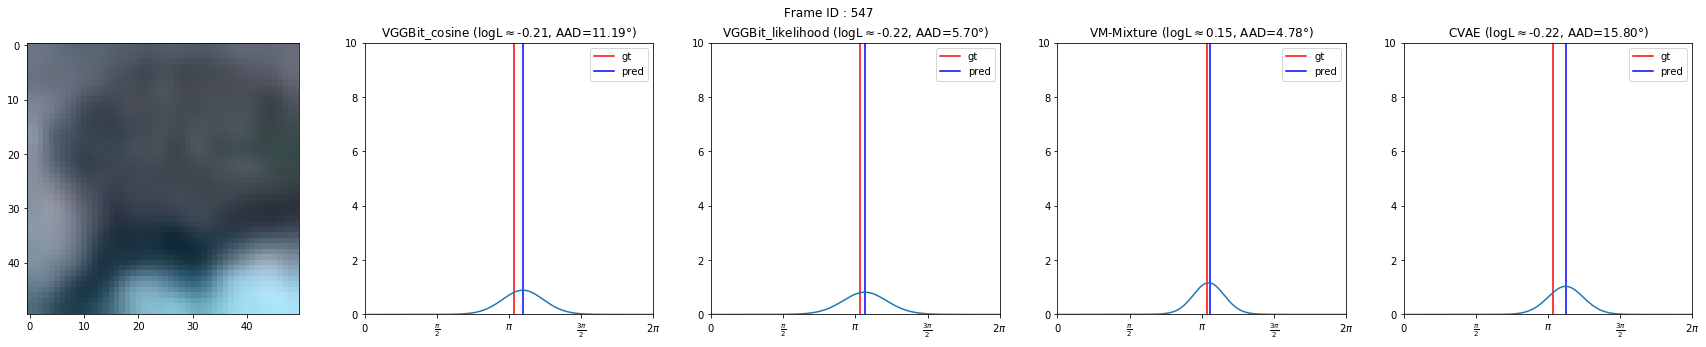

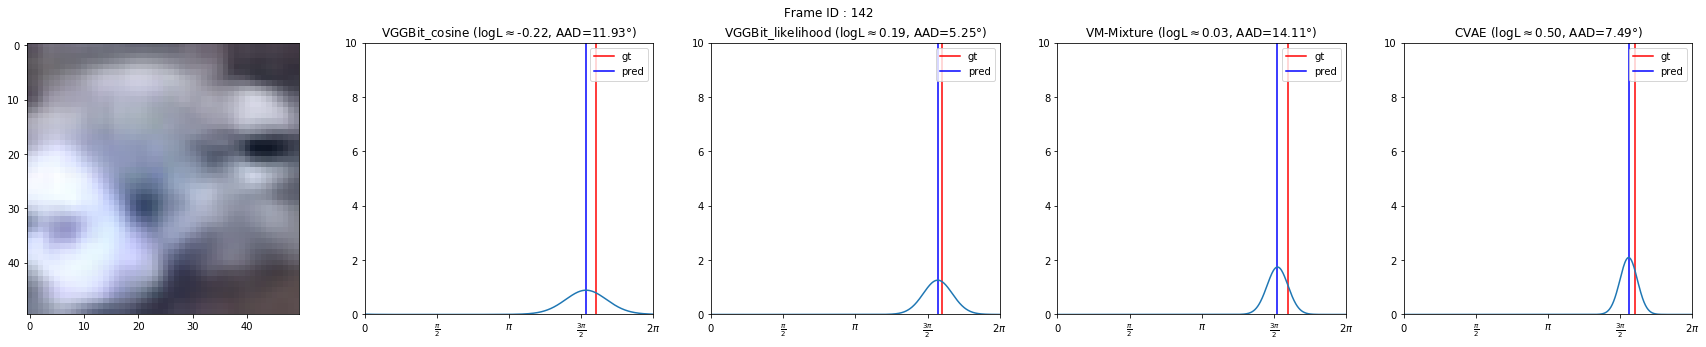

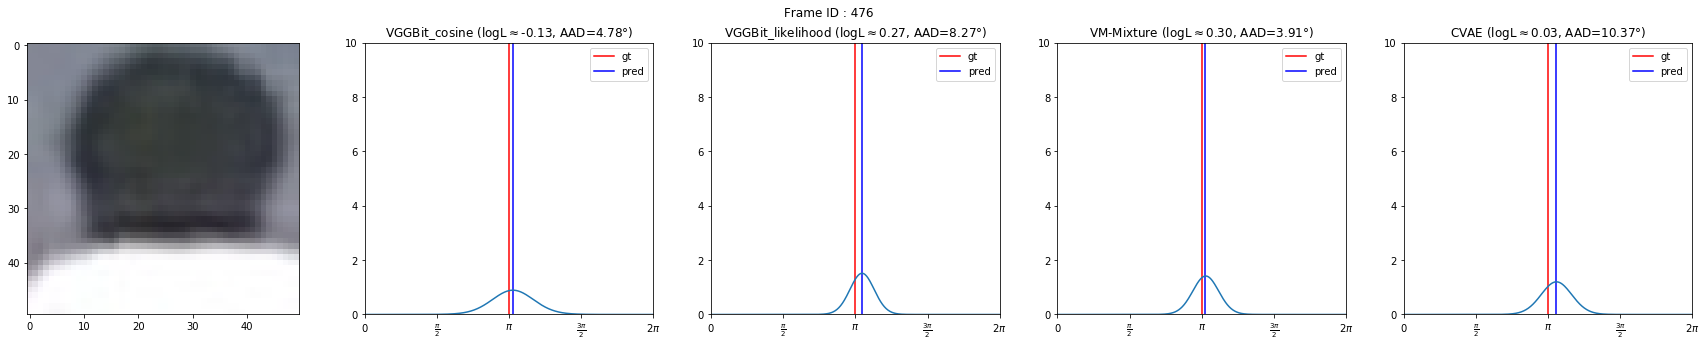

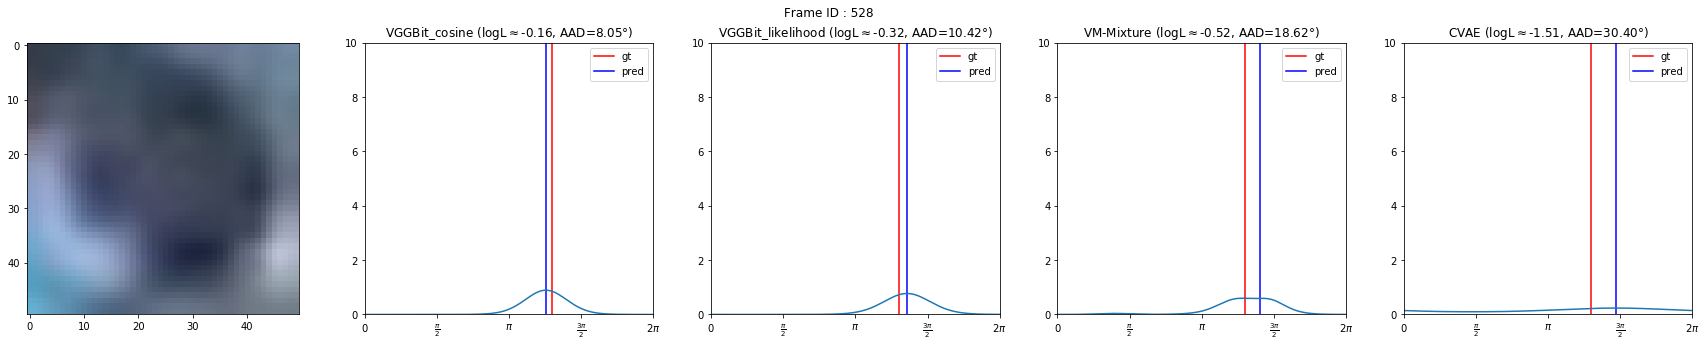

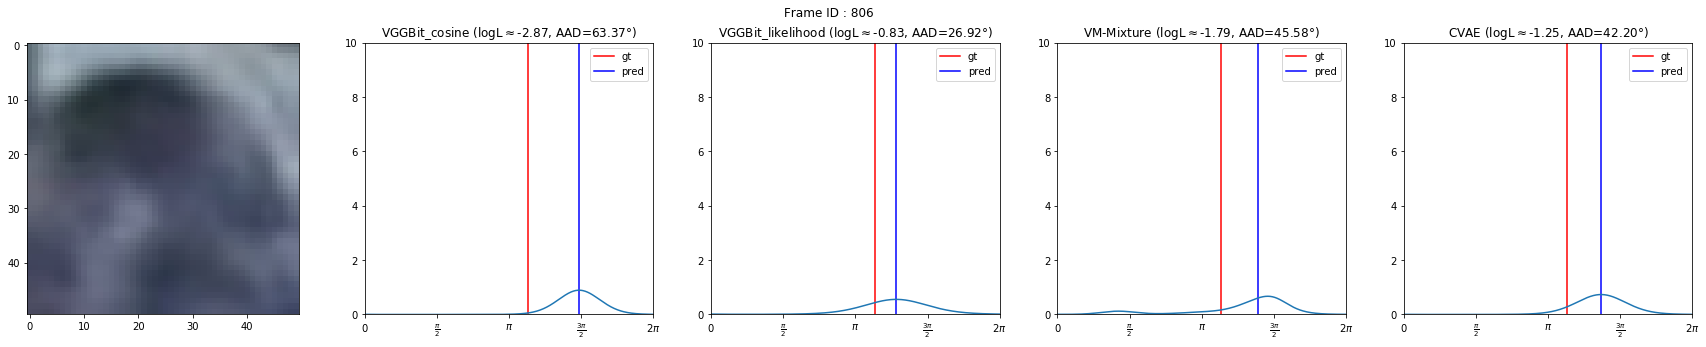

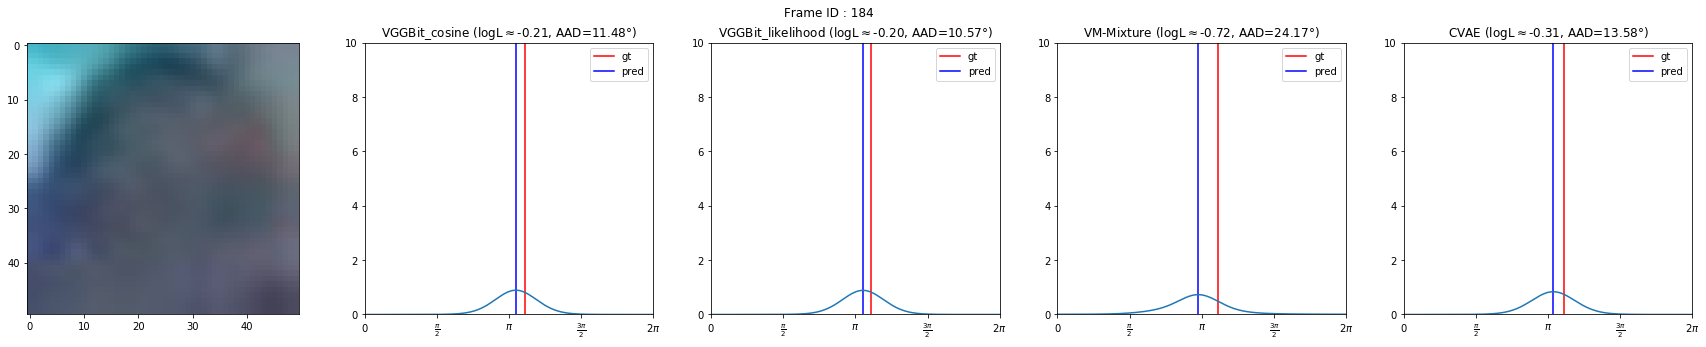

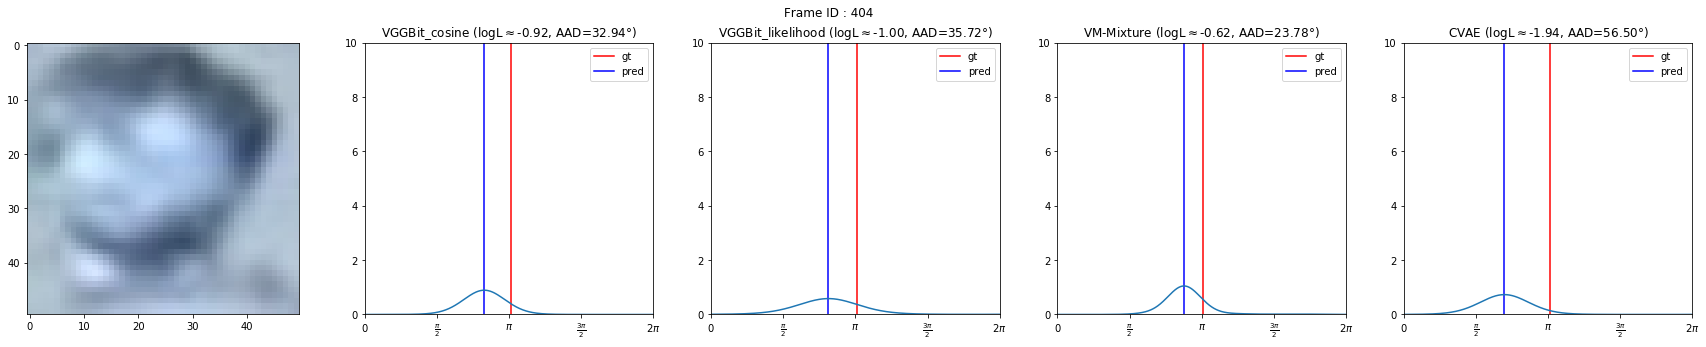

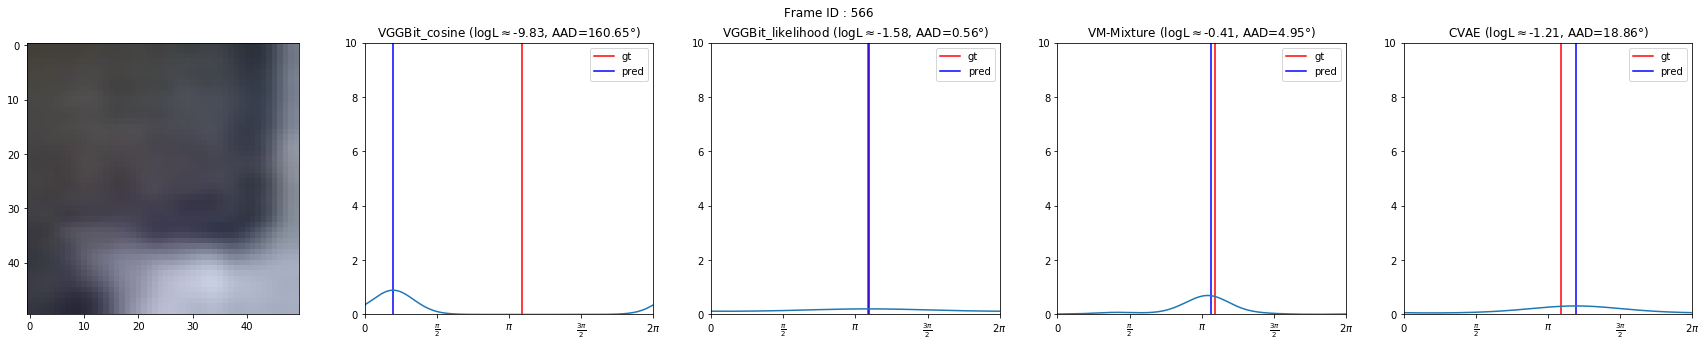

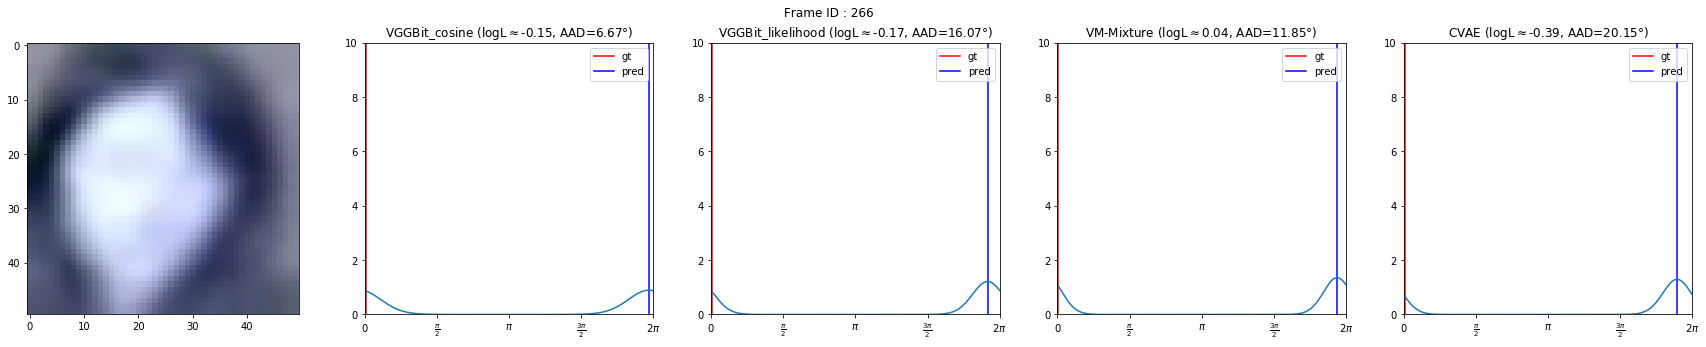

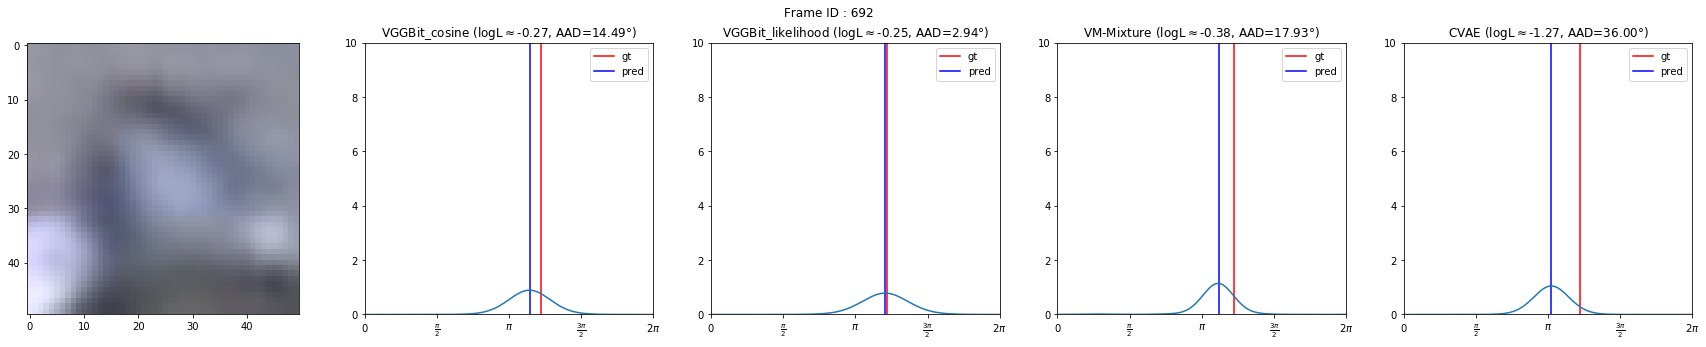

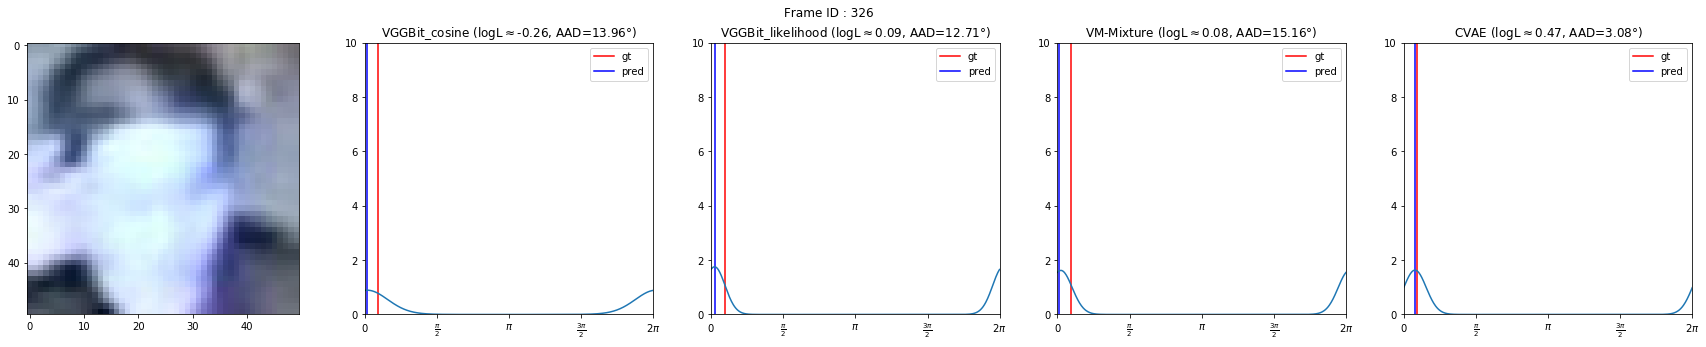

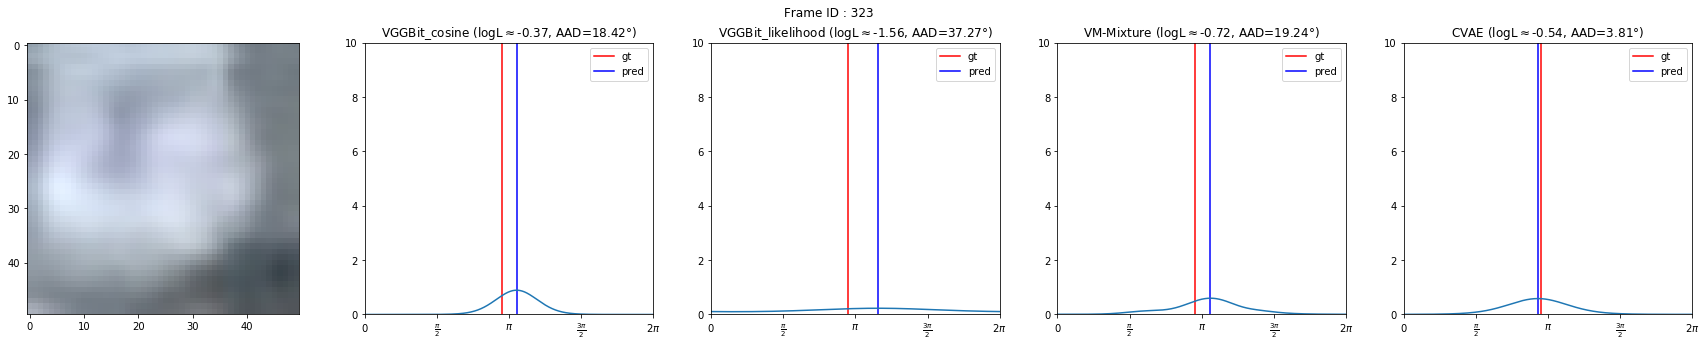

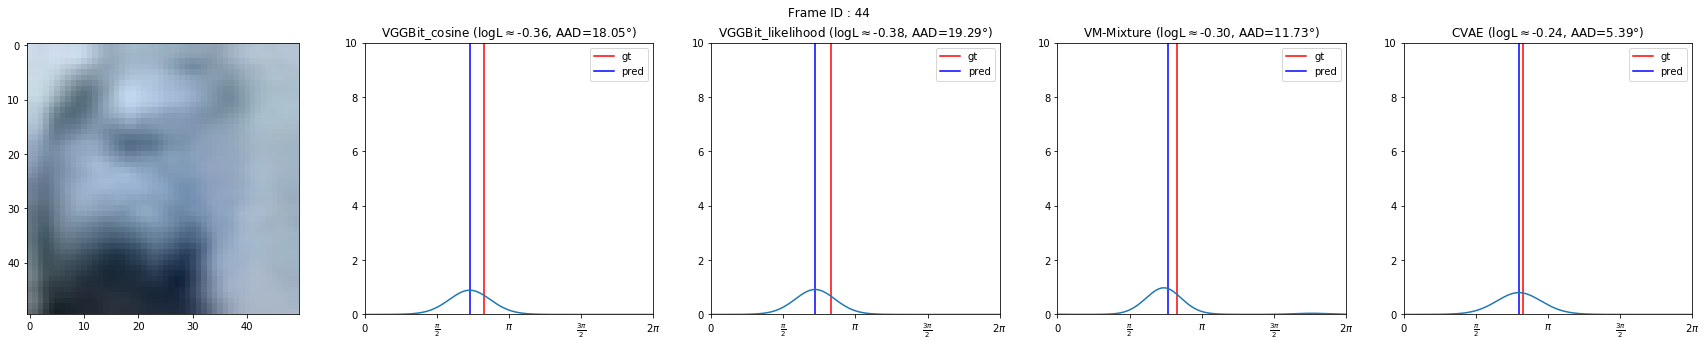

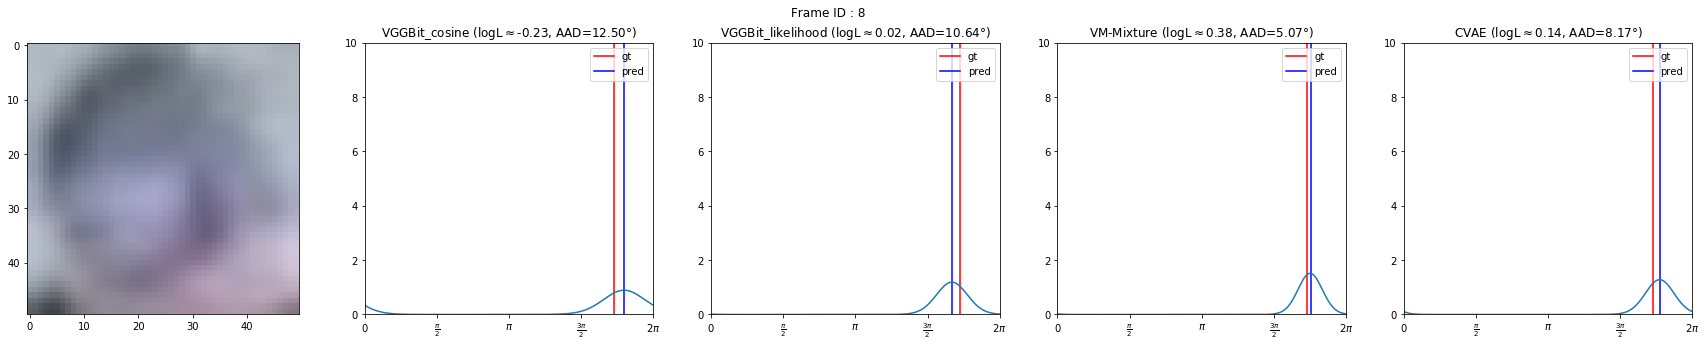

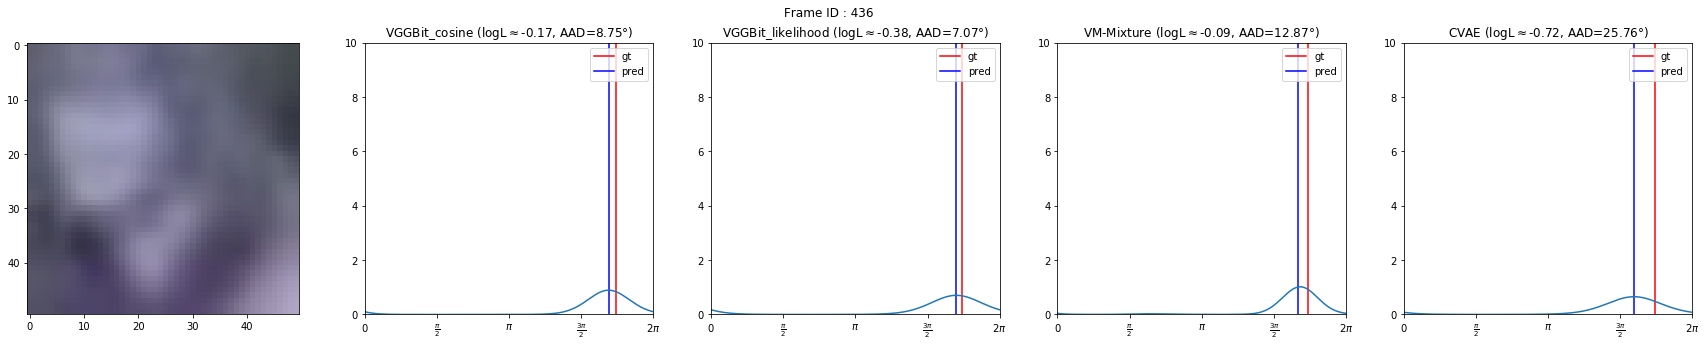

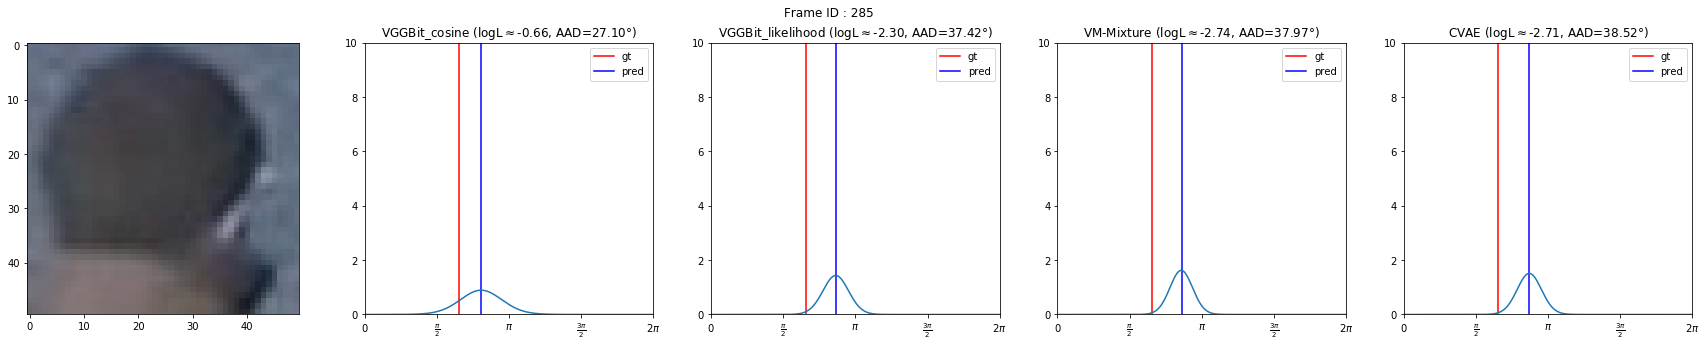

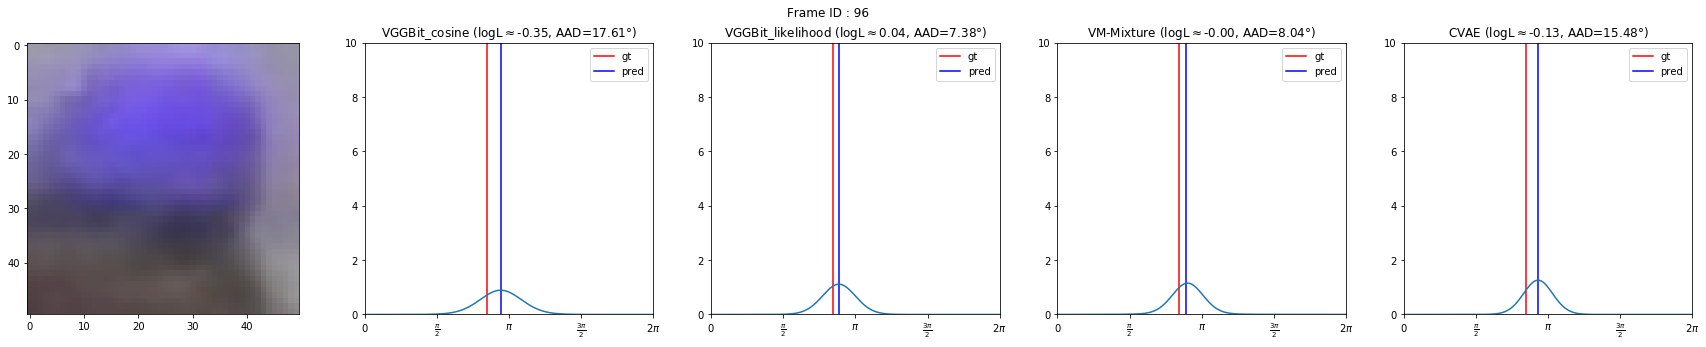

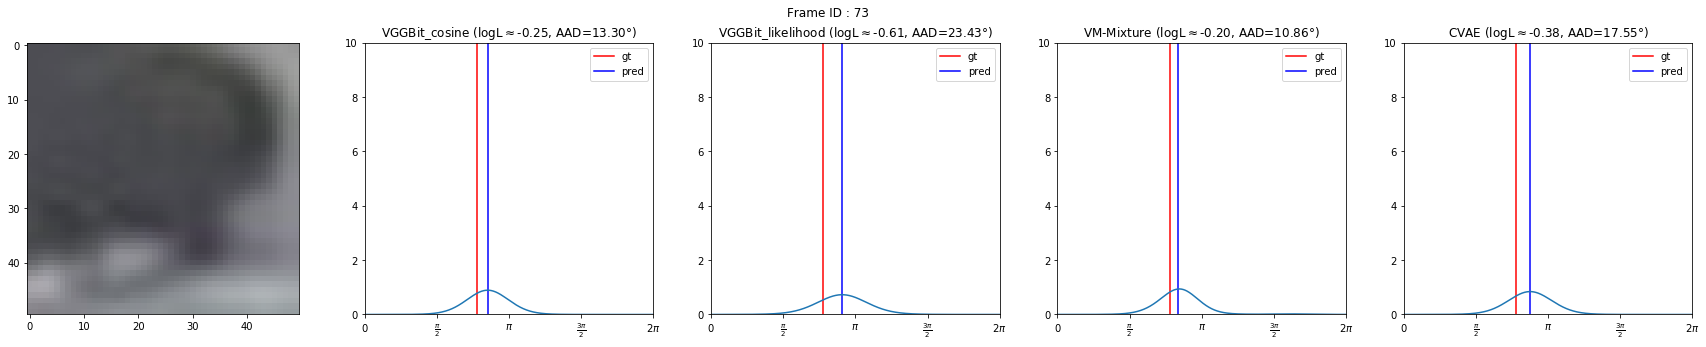

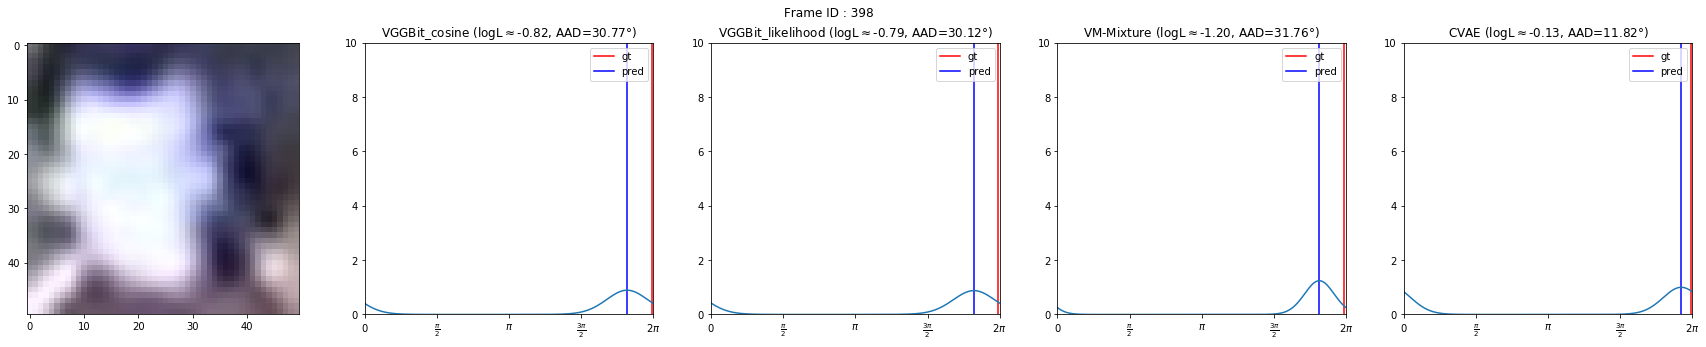

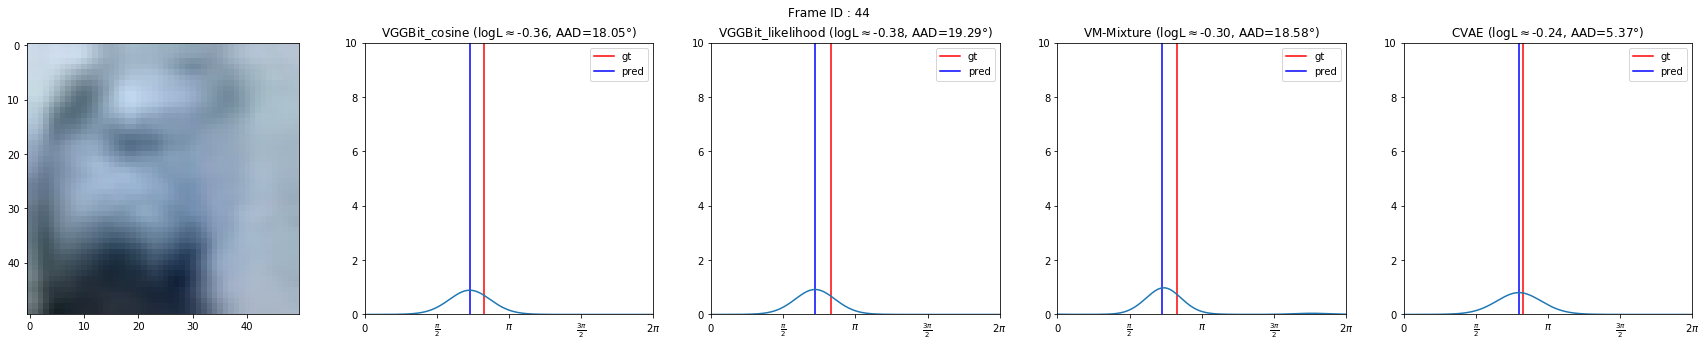

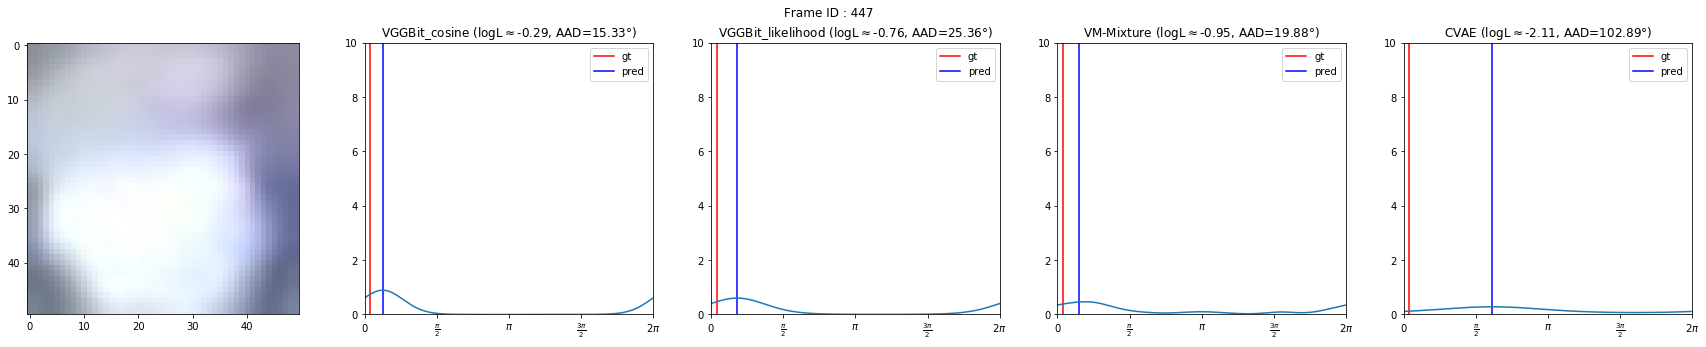

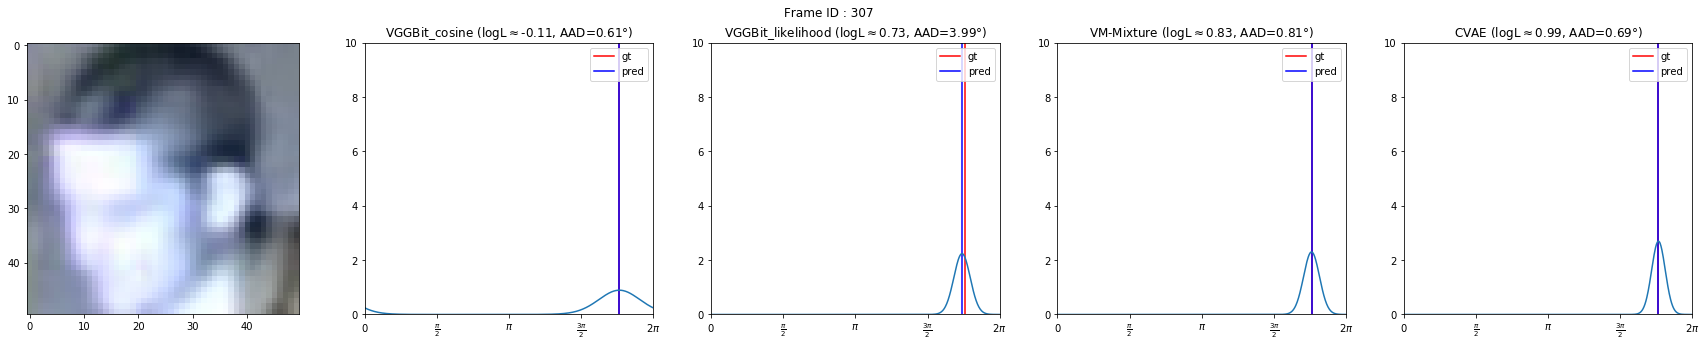

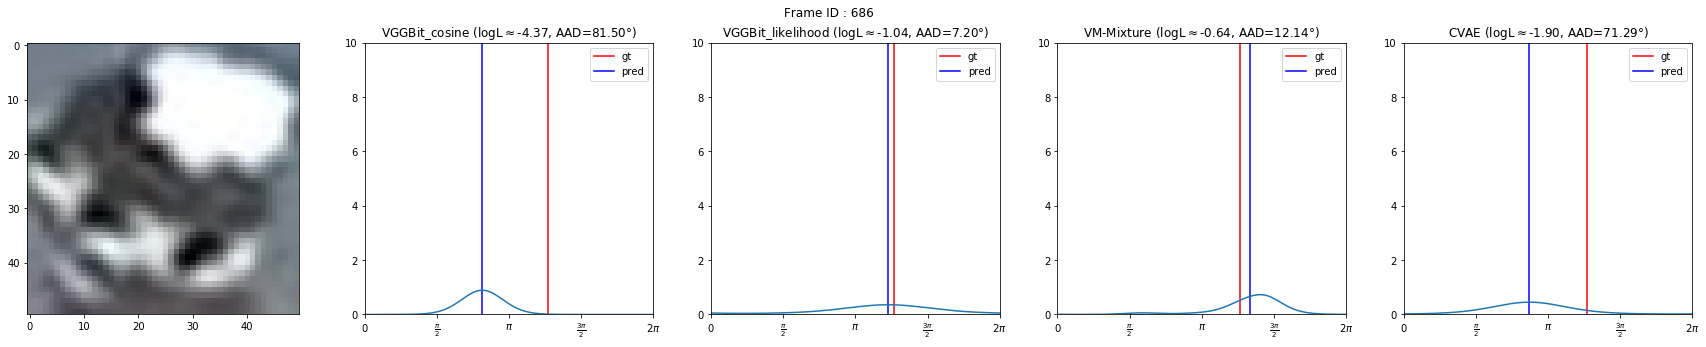

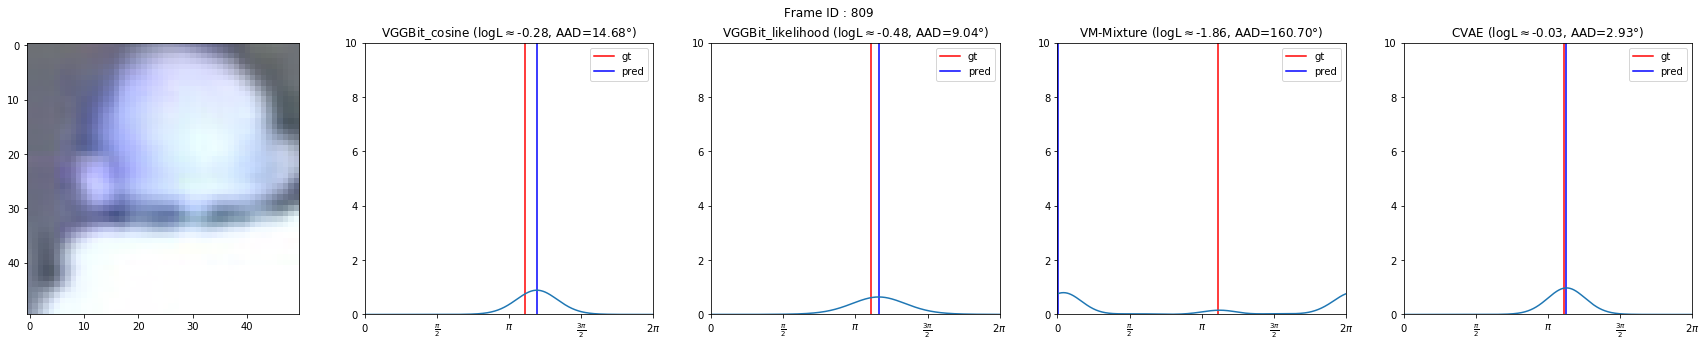

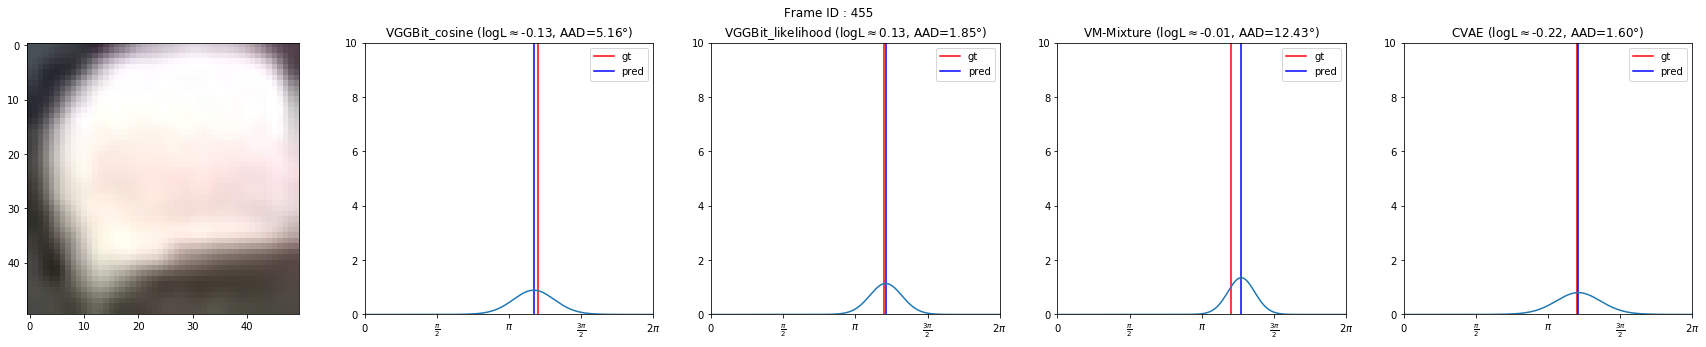

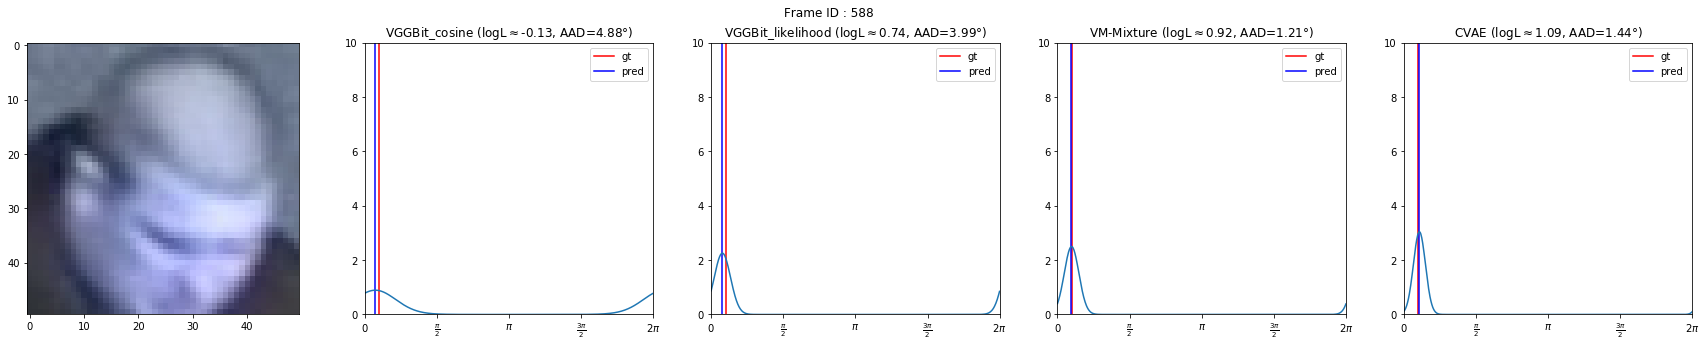

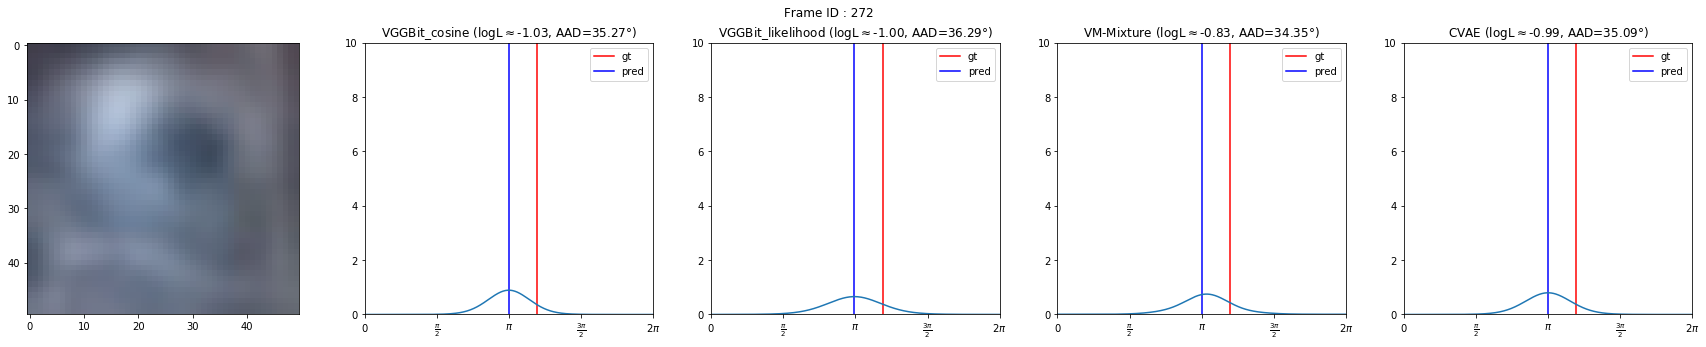

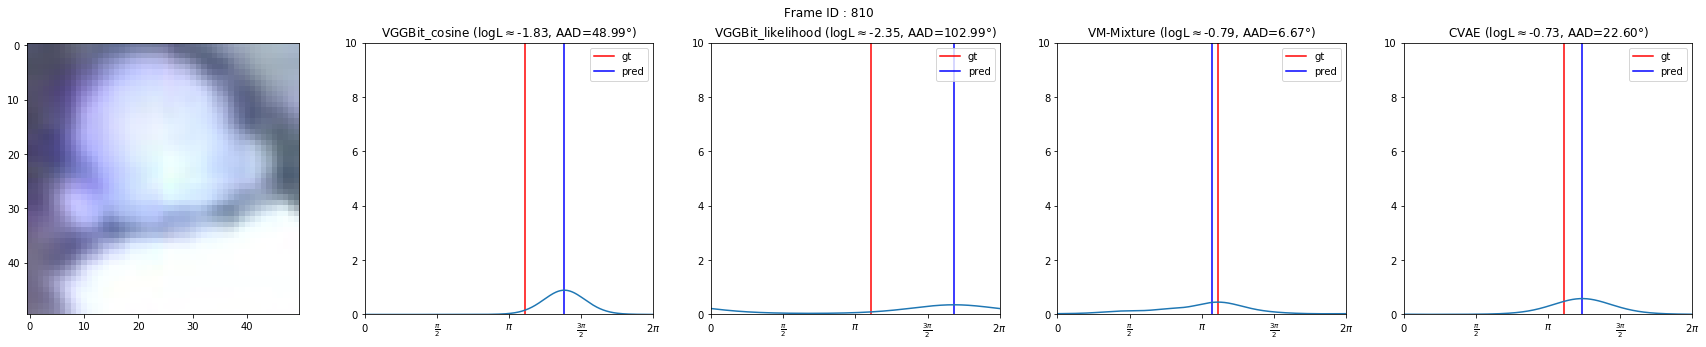

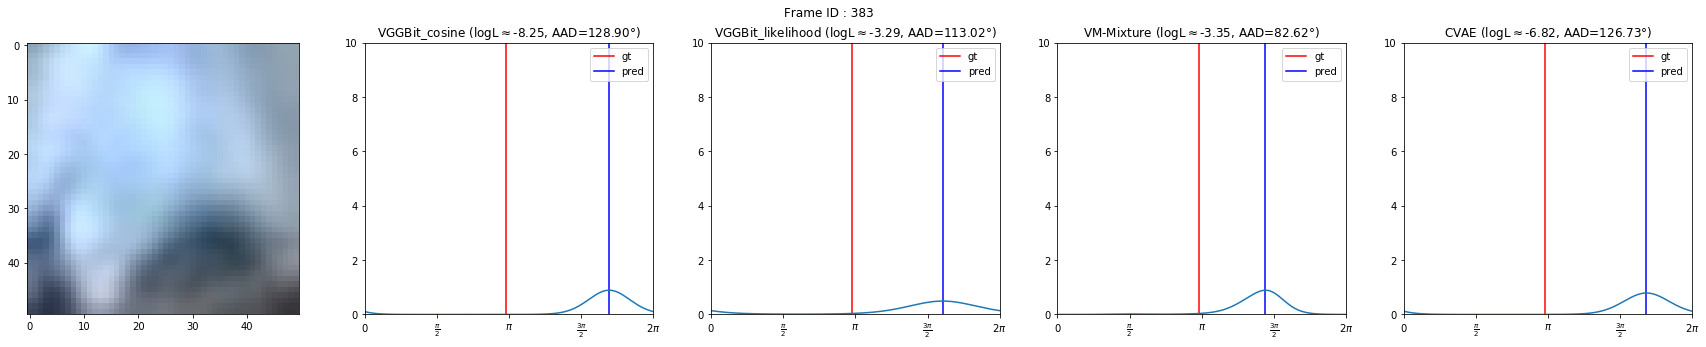

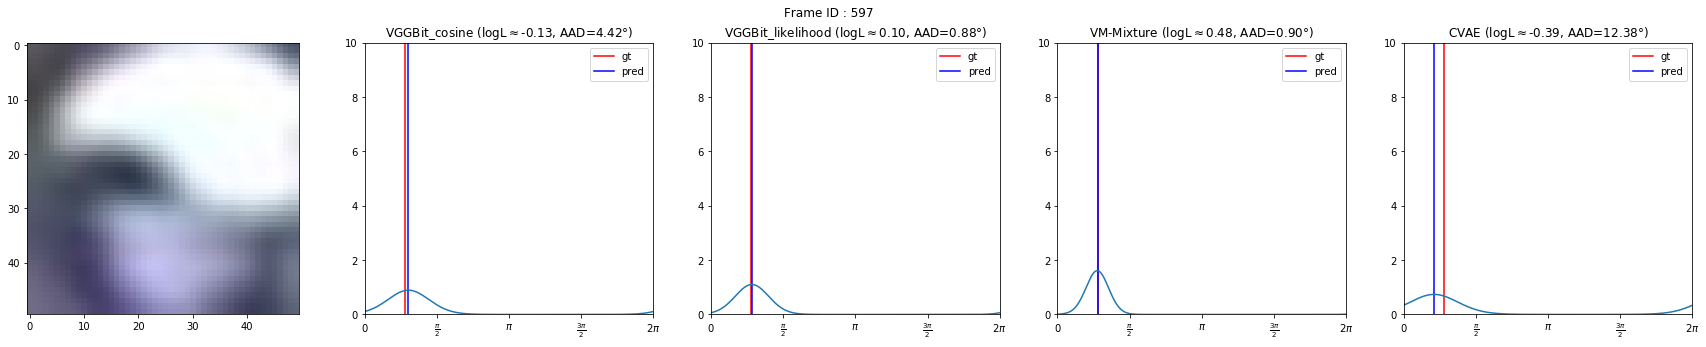

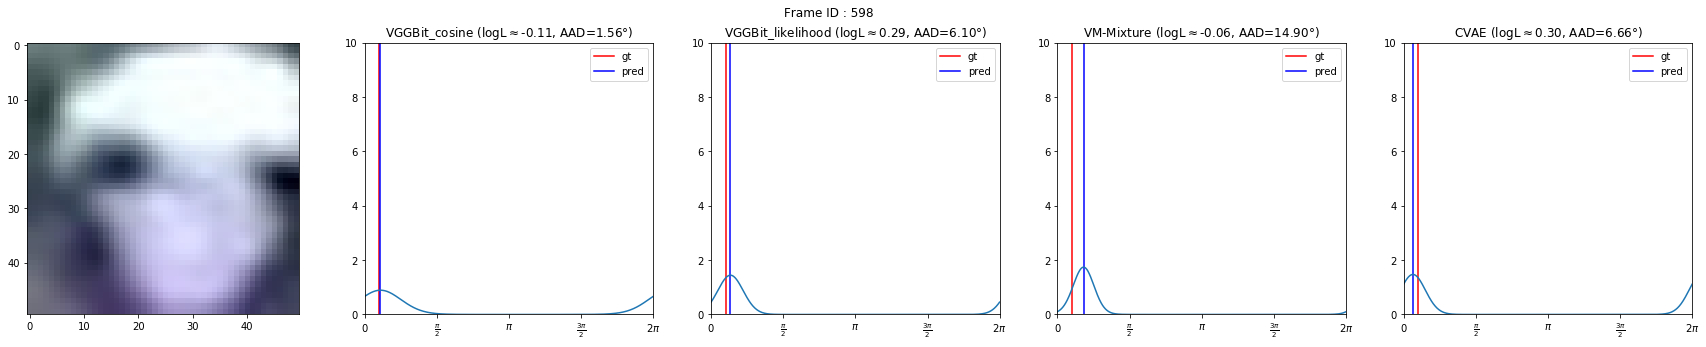

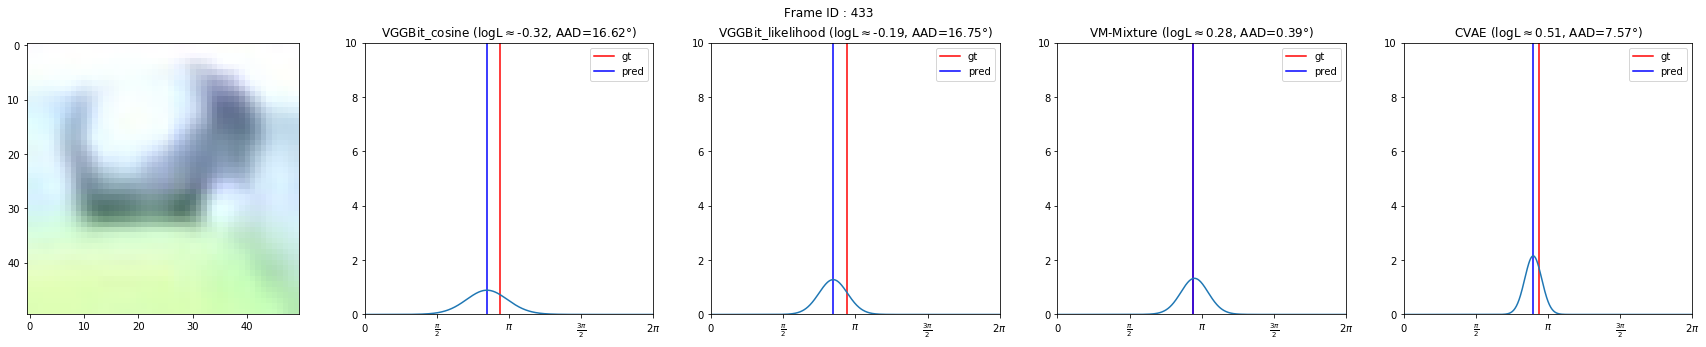

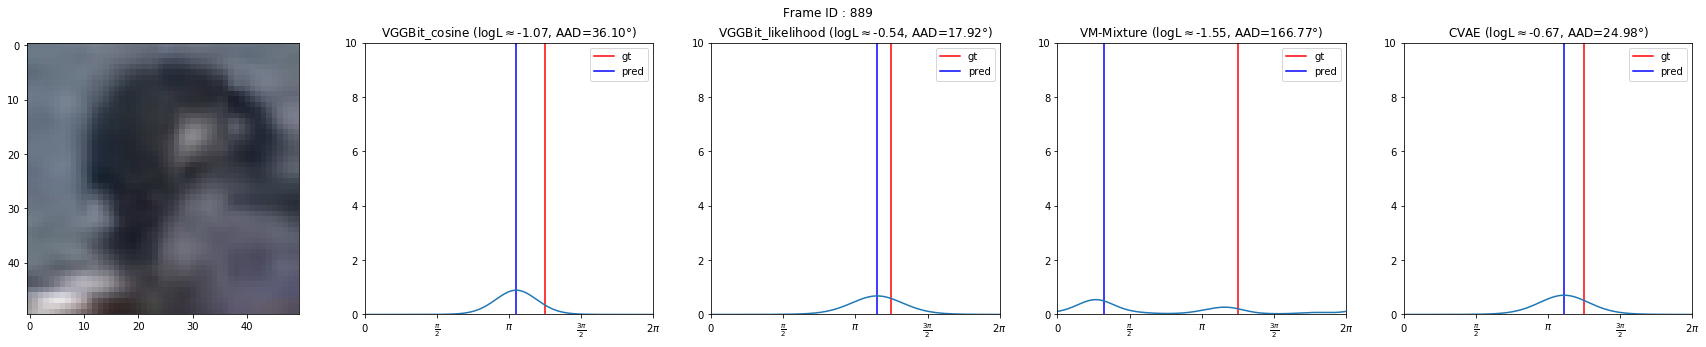

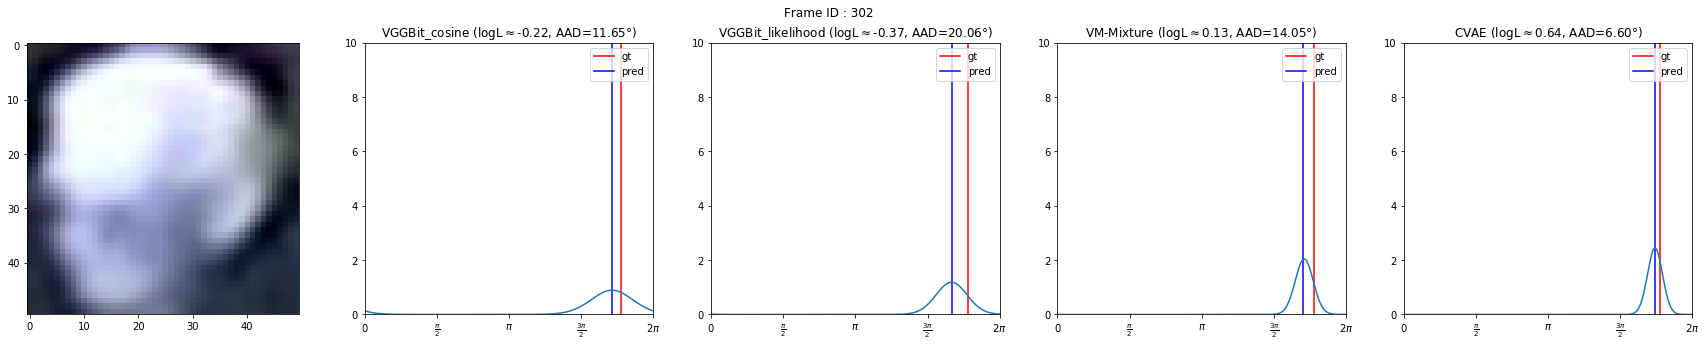

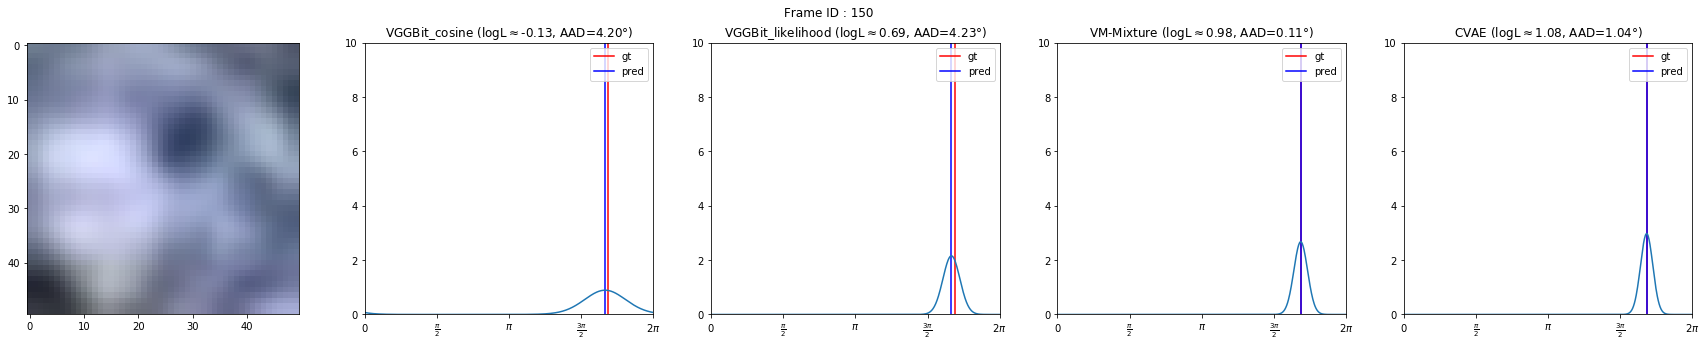

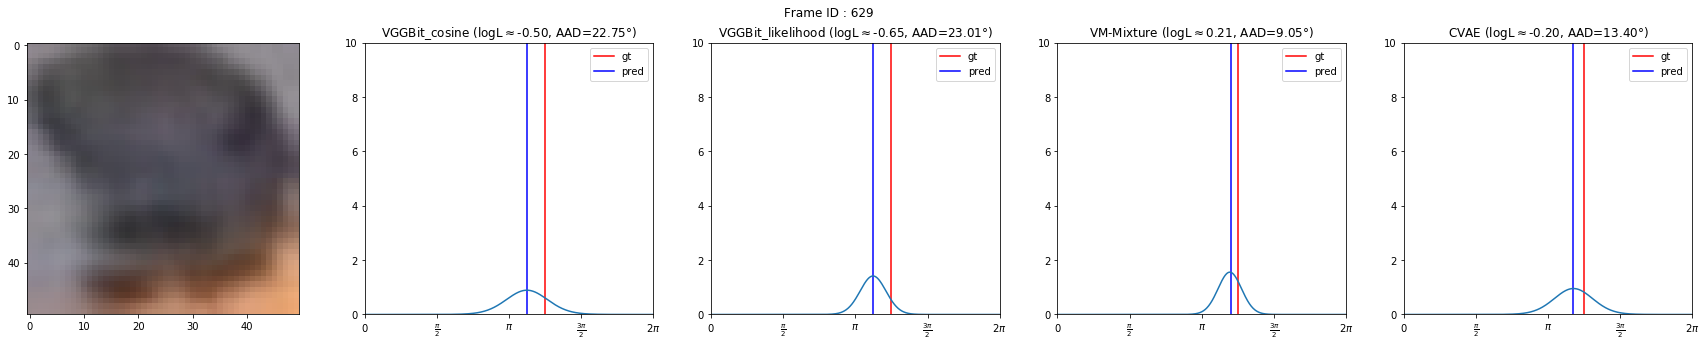

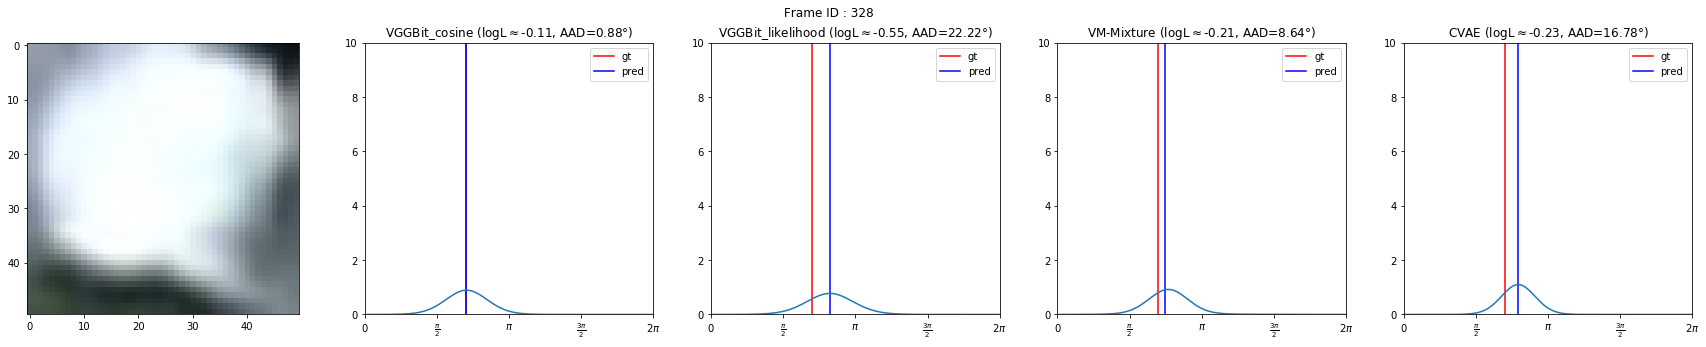

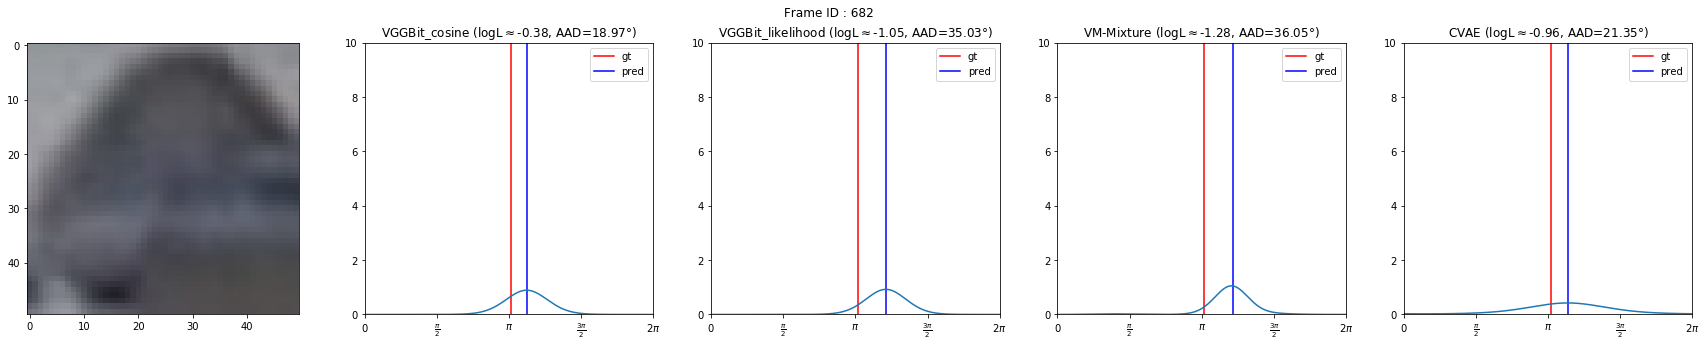

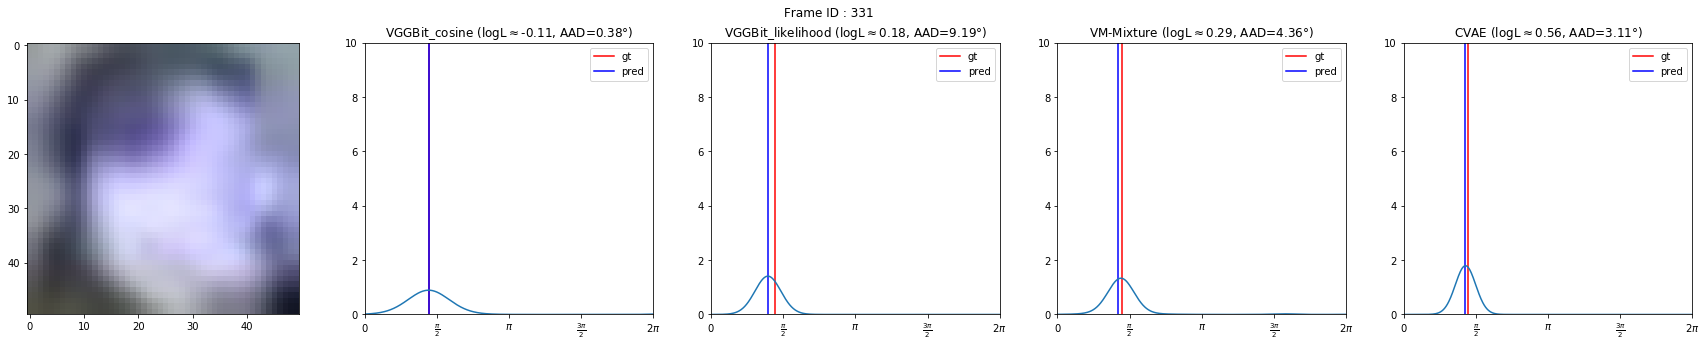

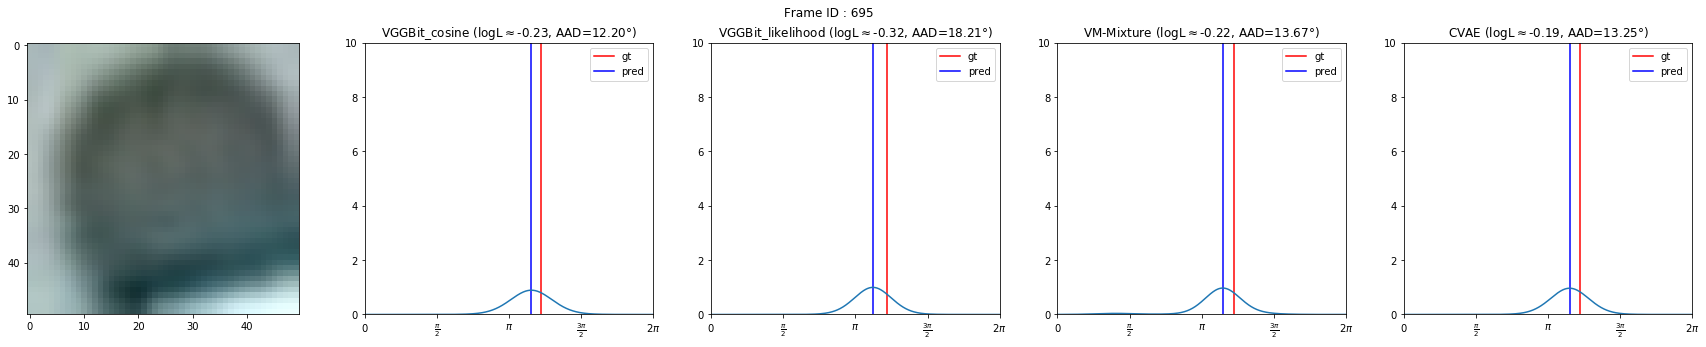

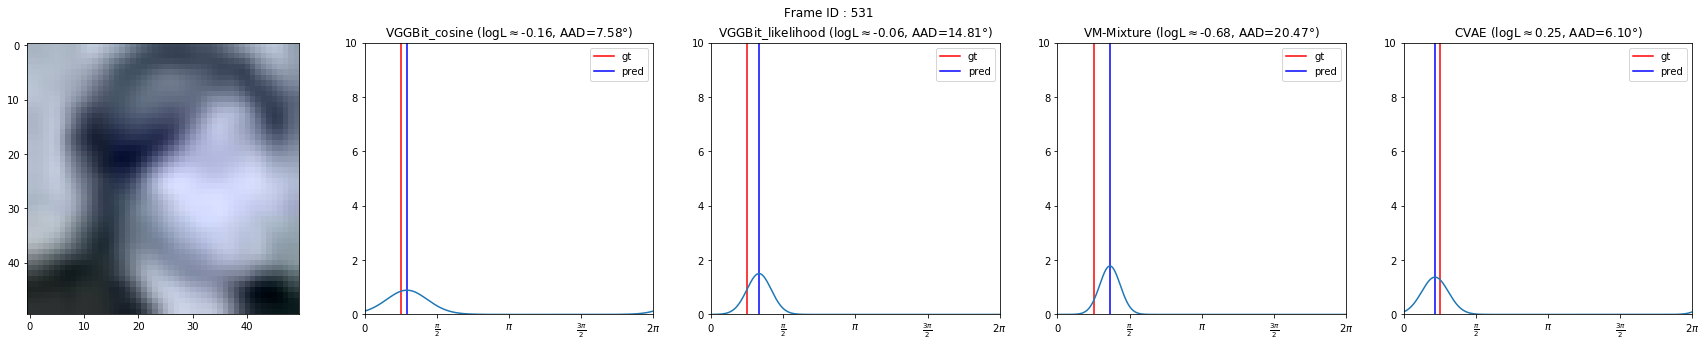

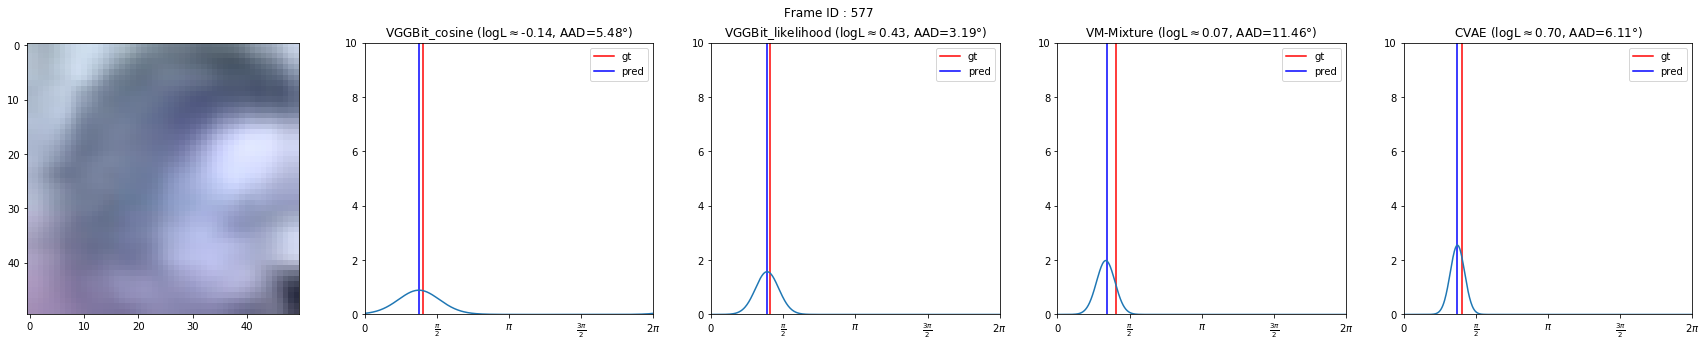

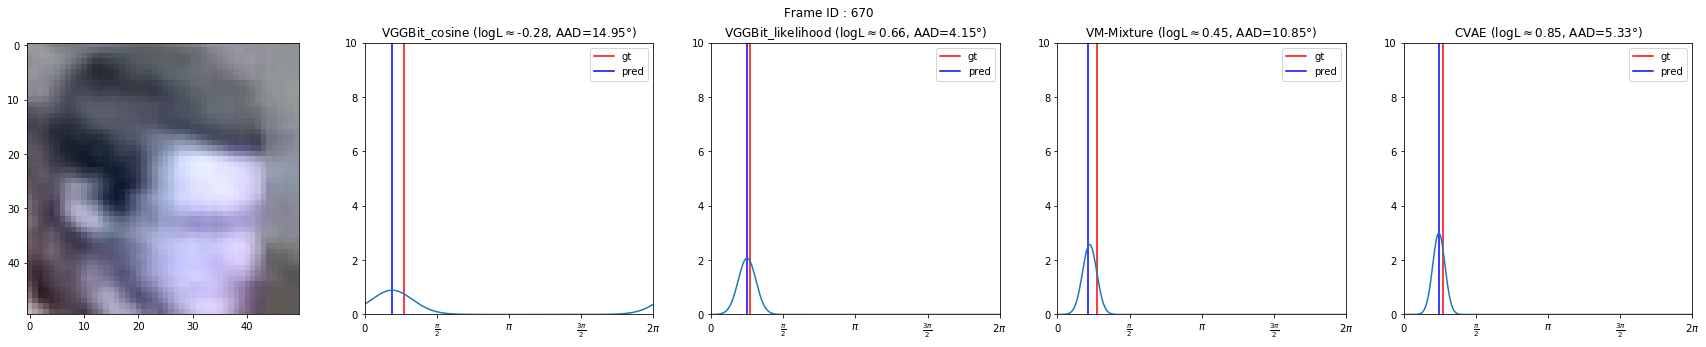

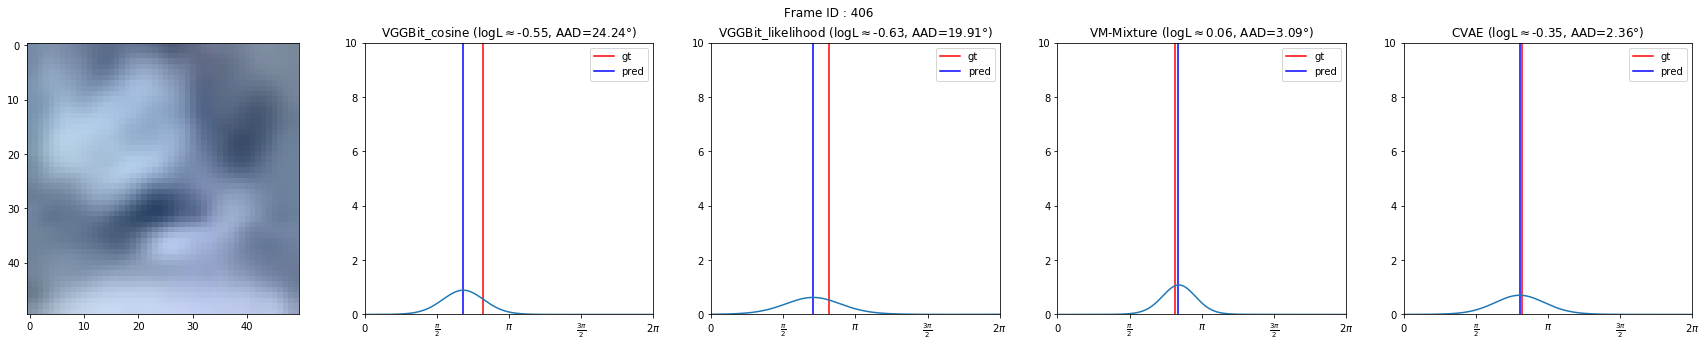

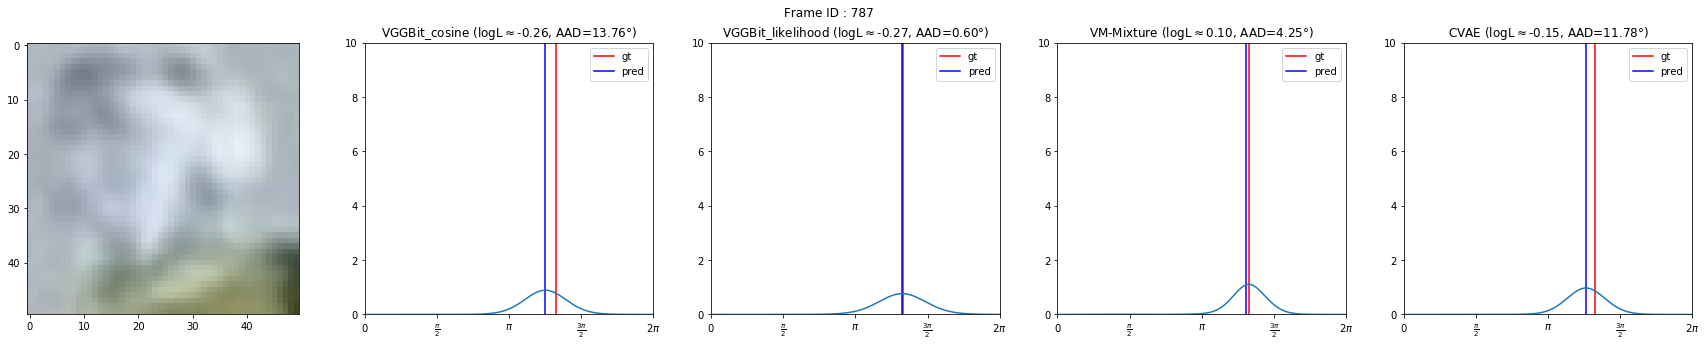

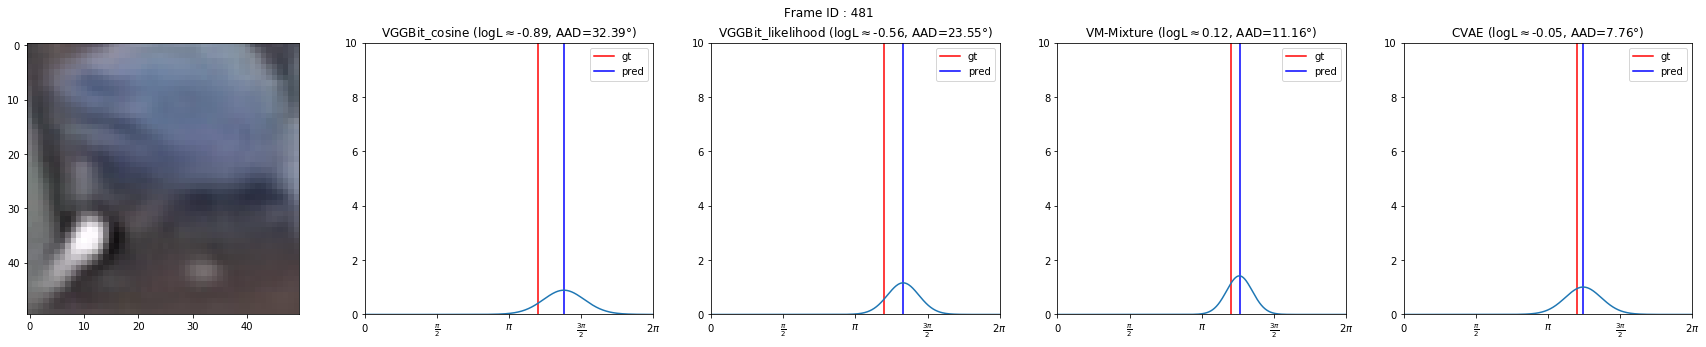

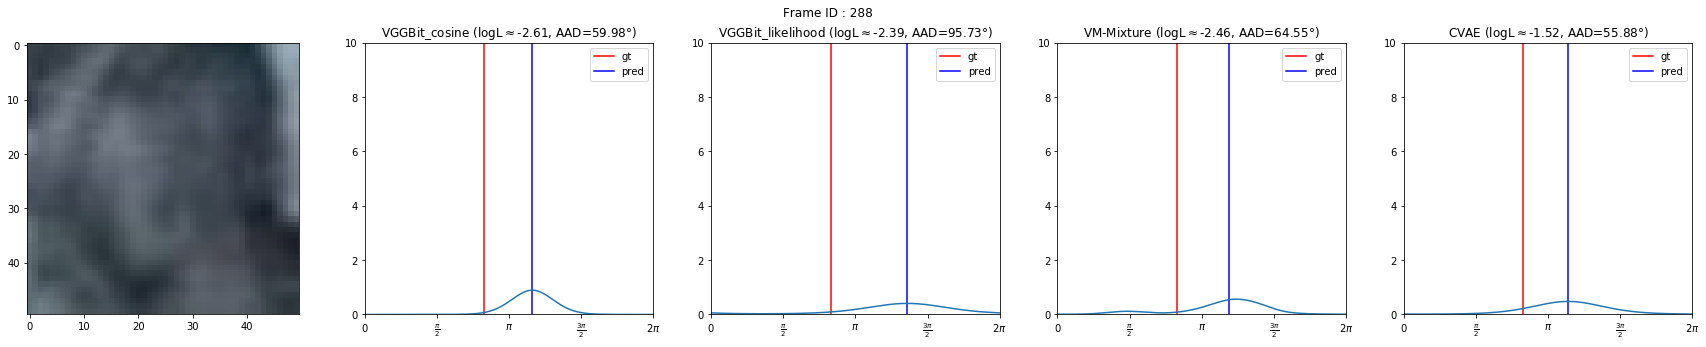

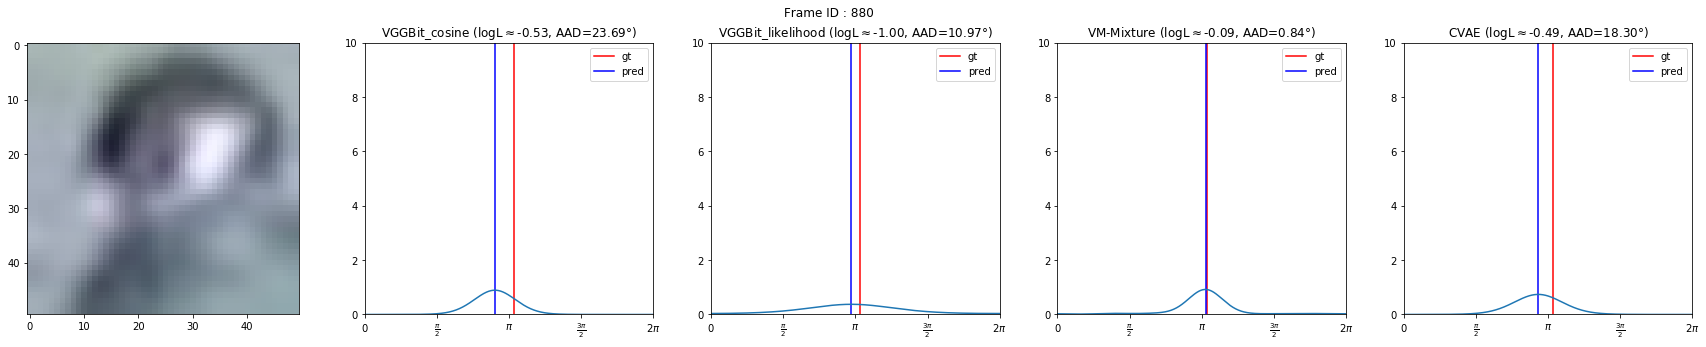

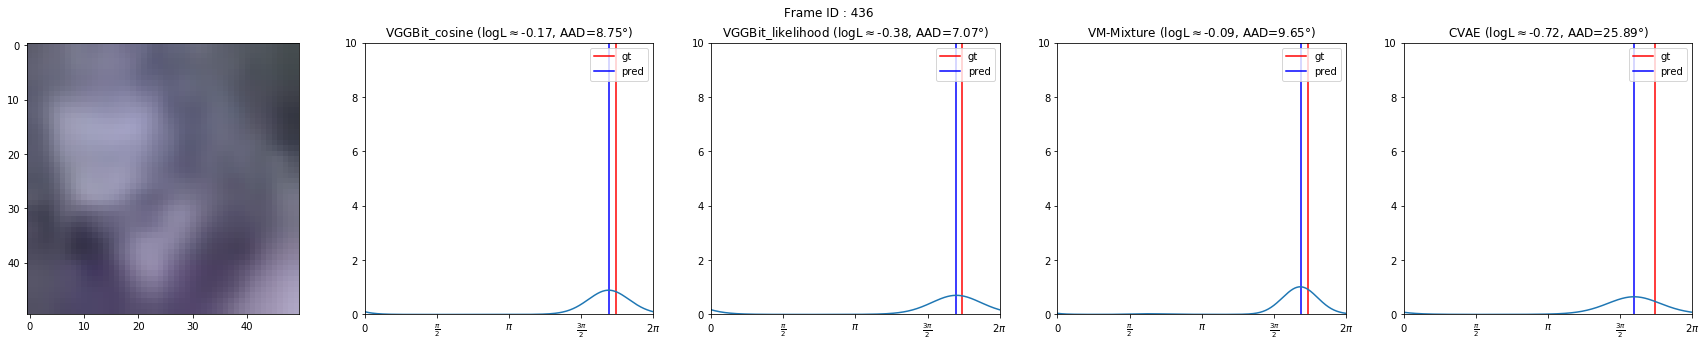

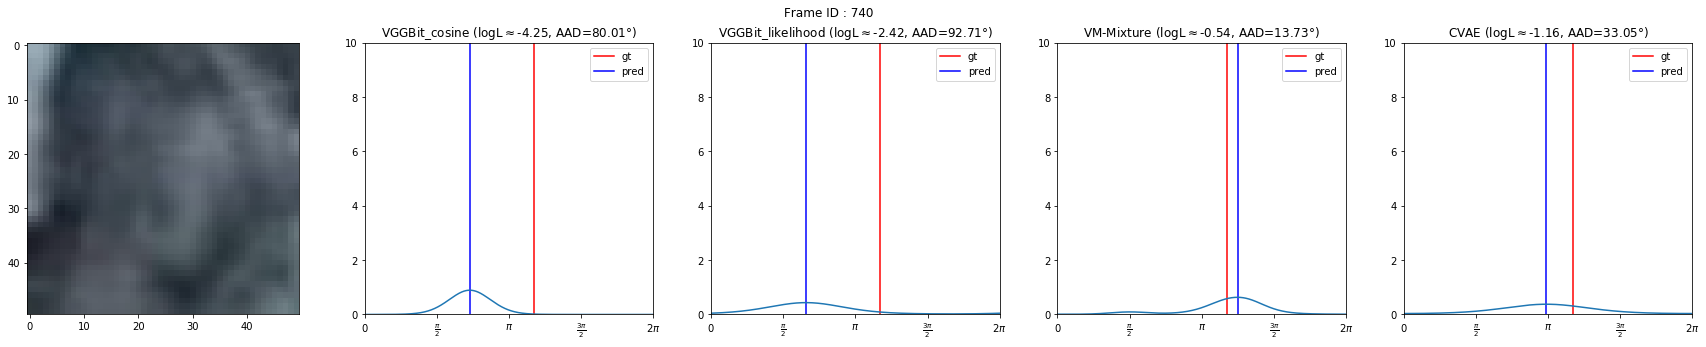

In [71]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

#### CVAE demo

/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


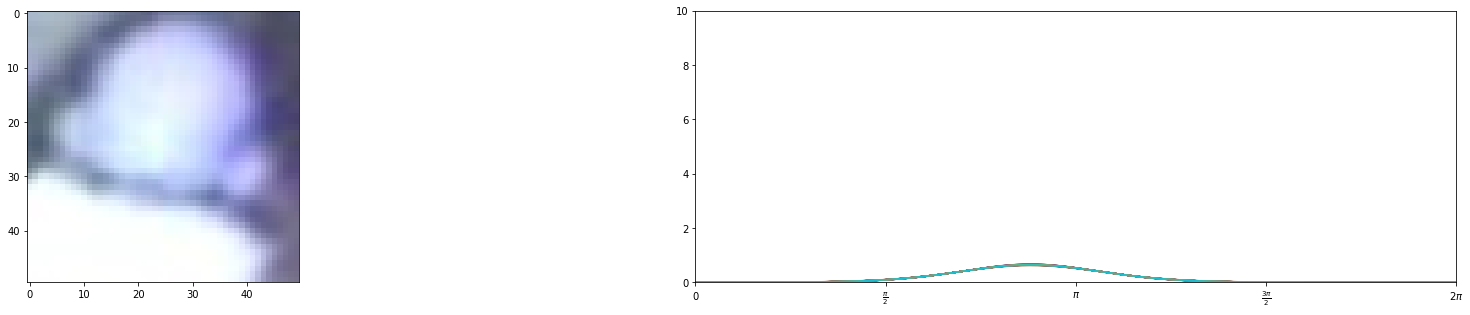

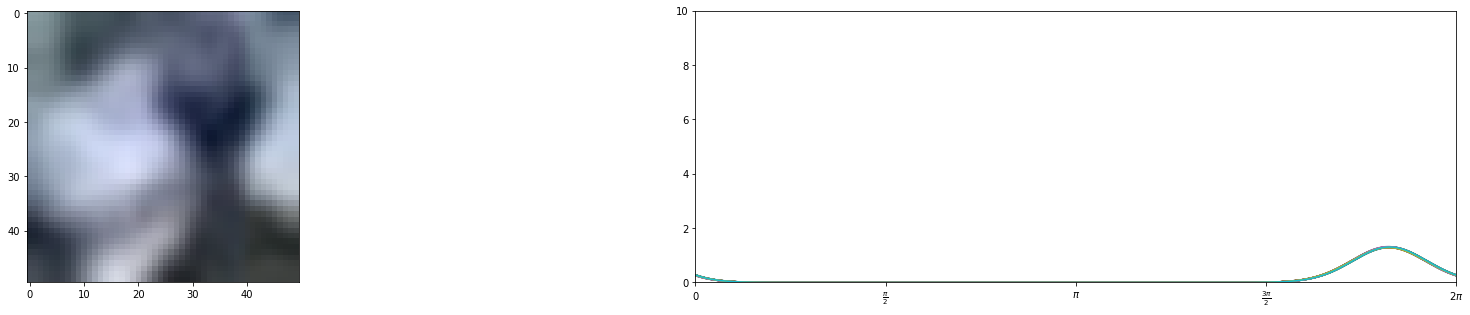

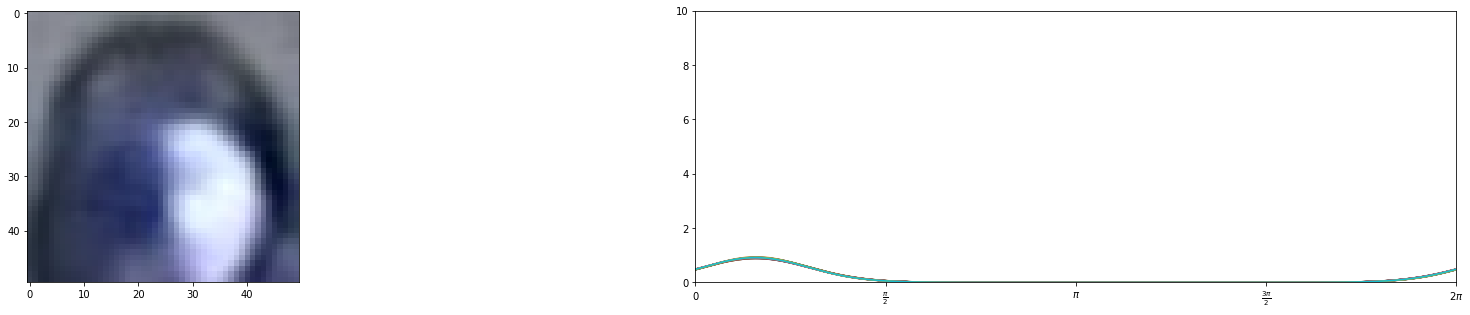

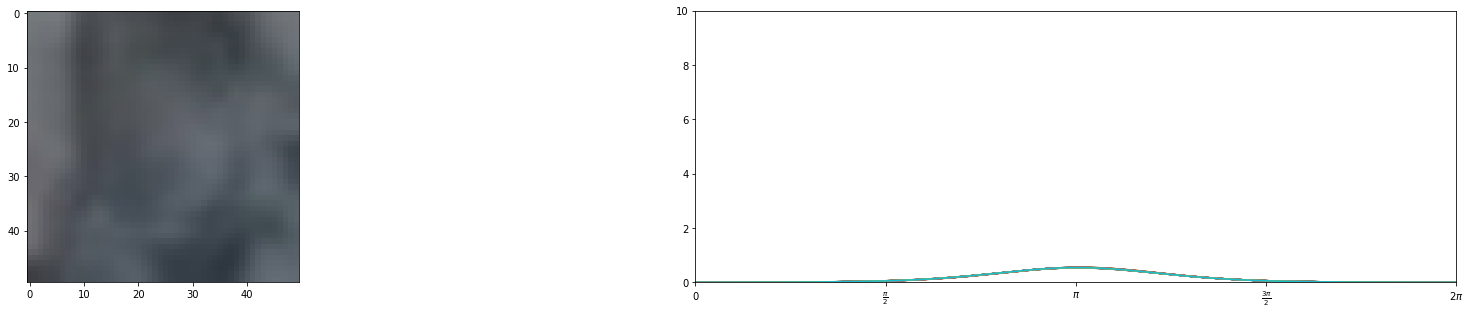

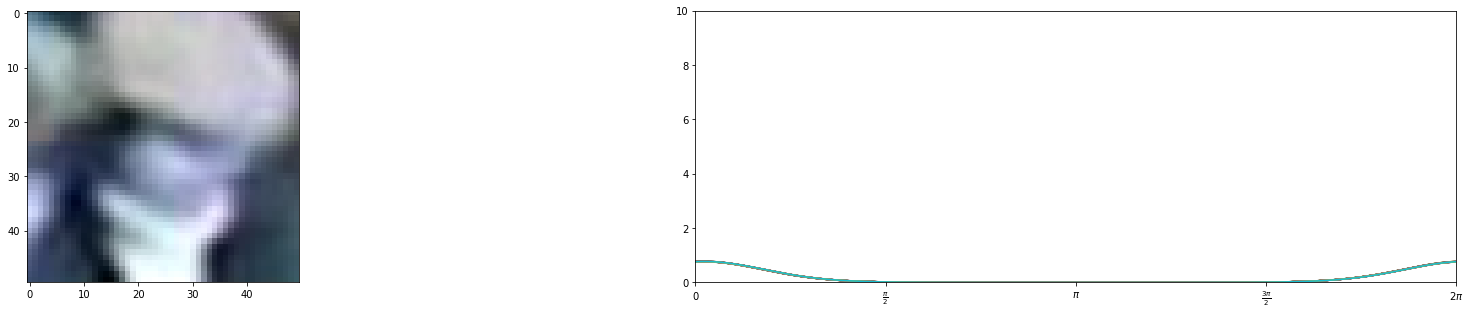

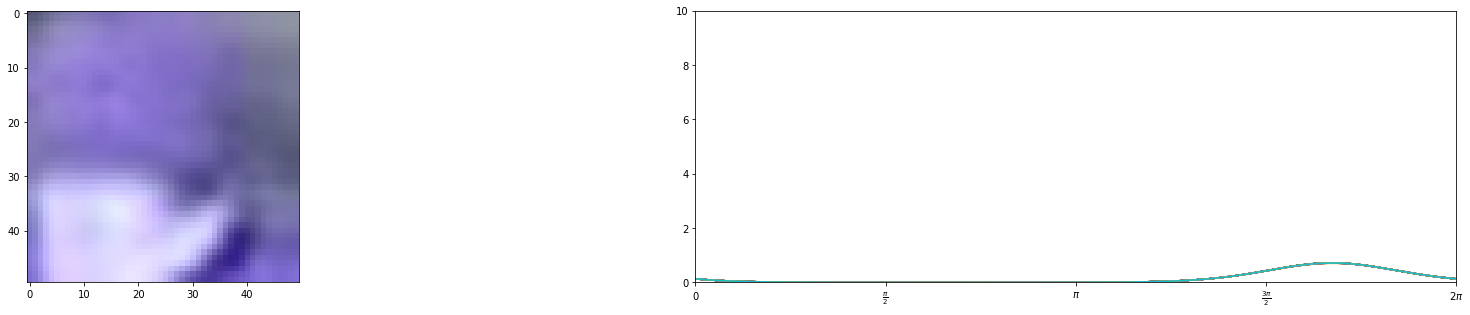

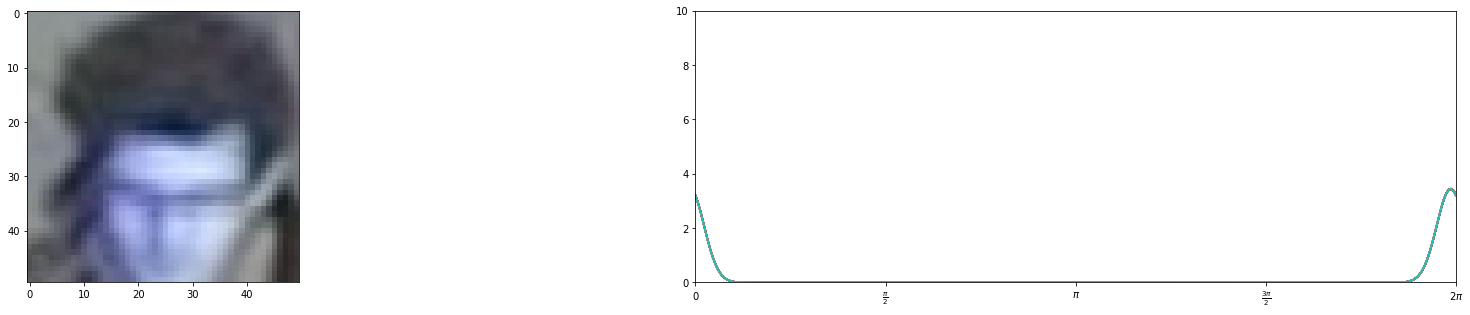

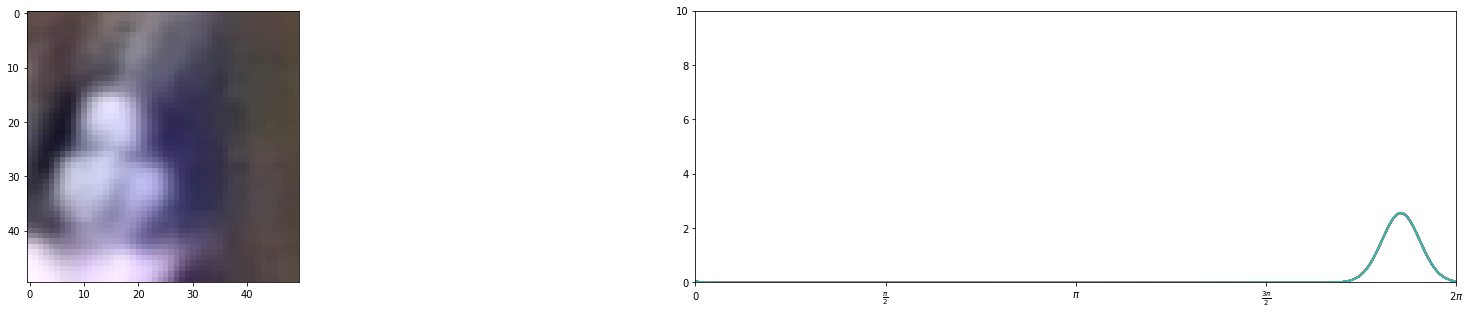

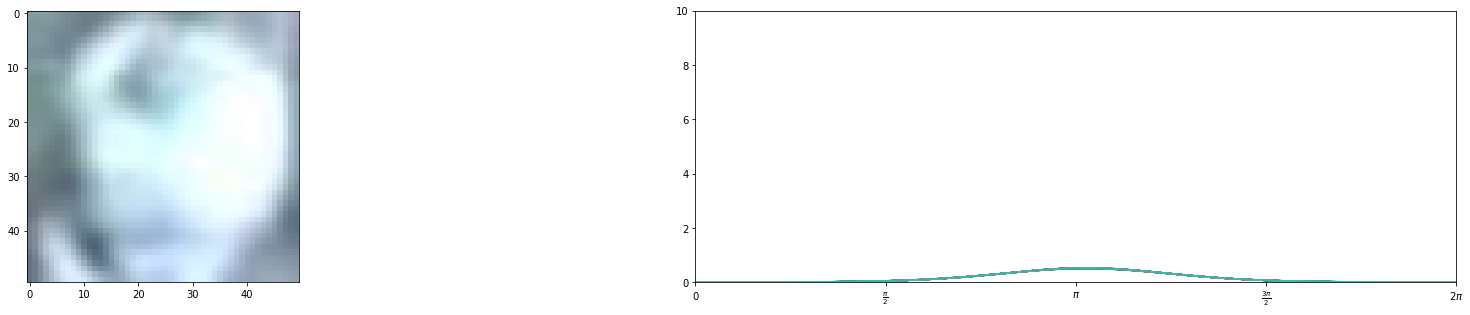

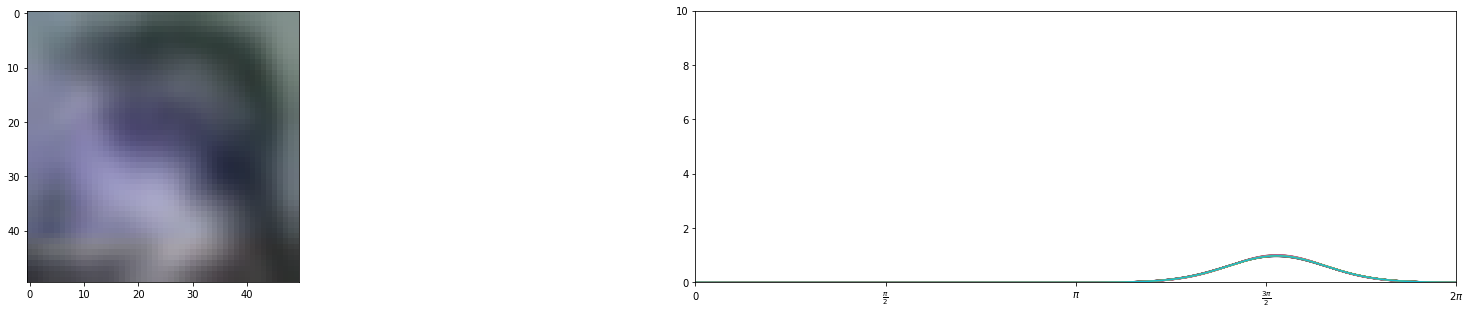

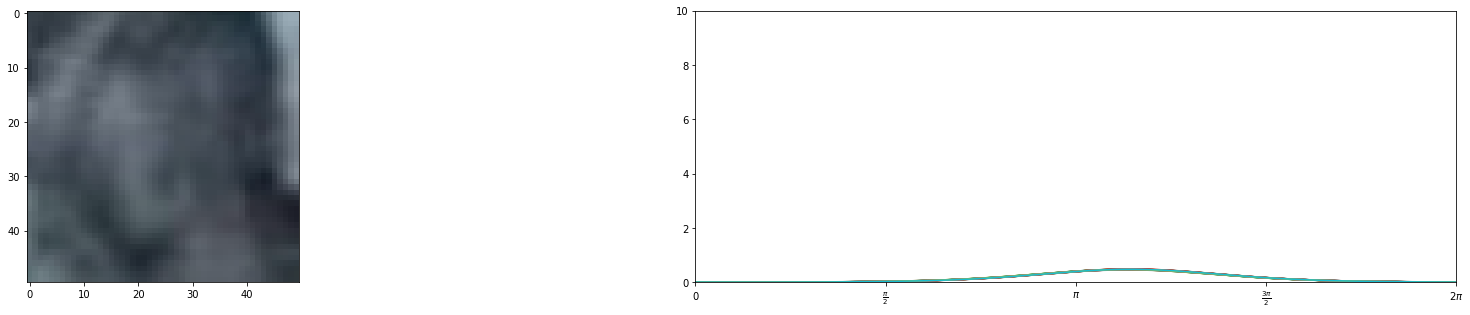

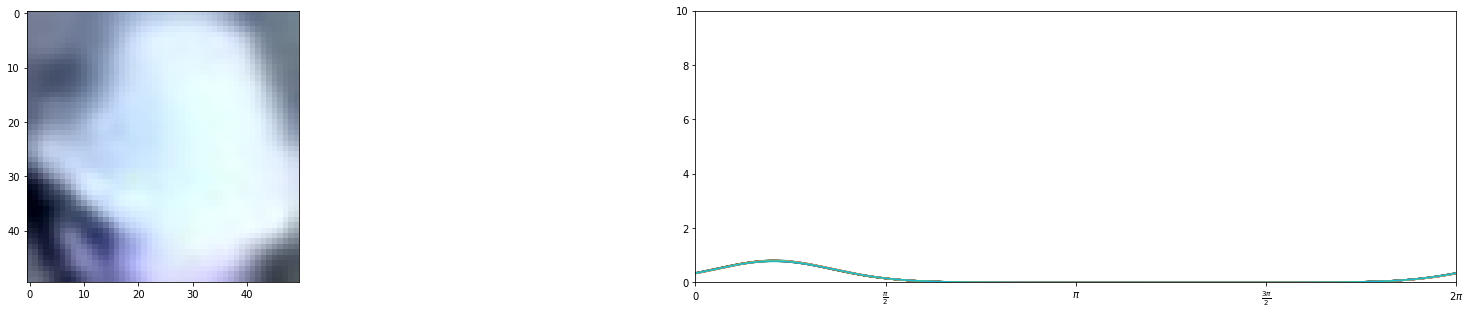

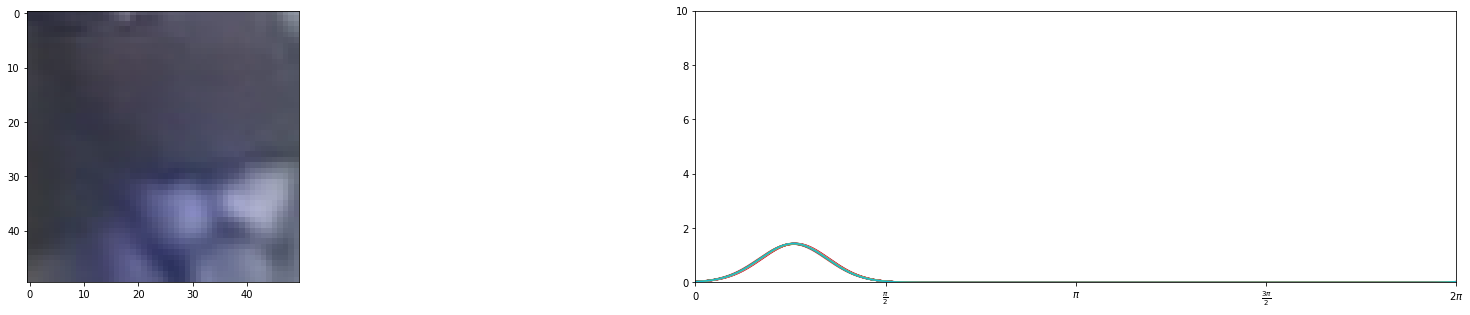

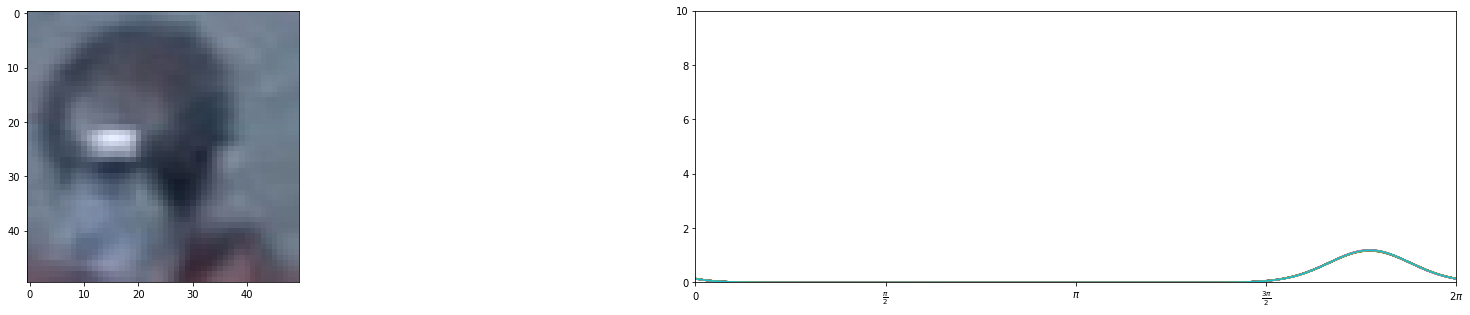

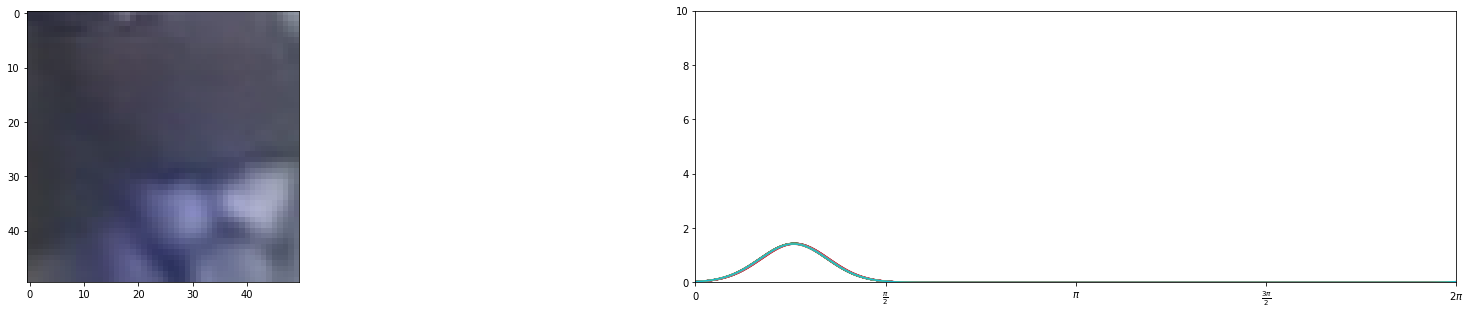

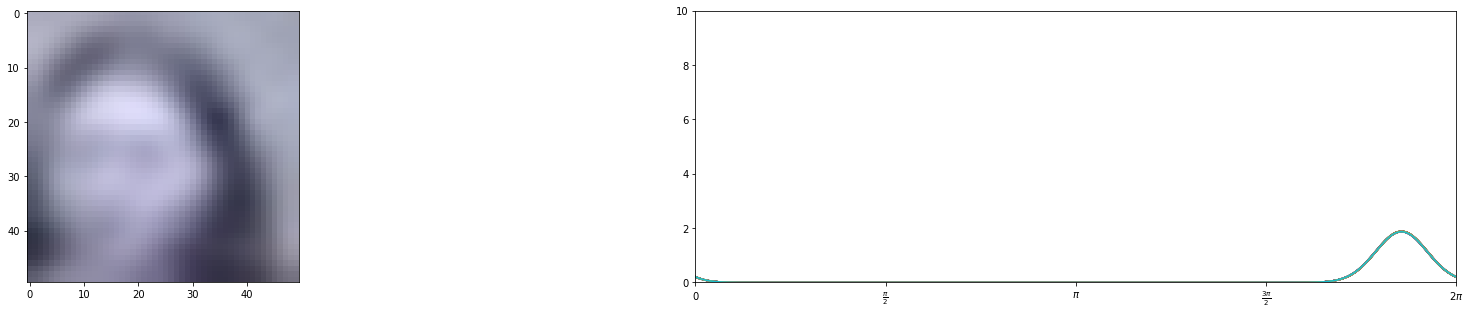

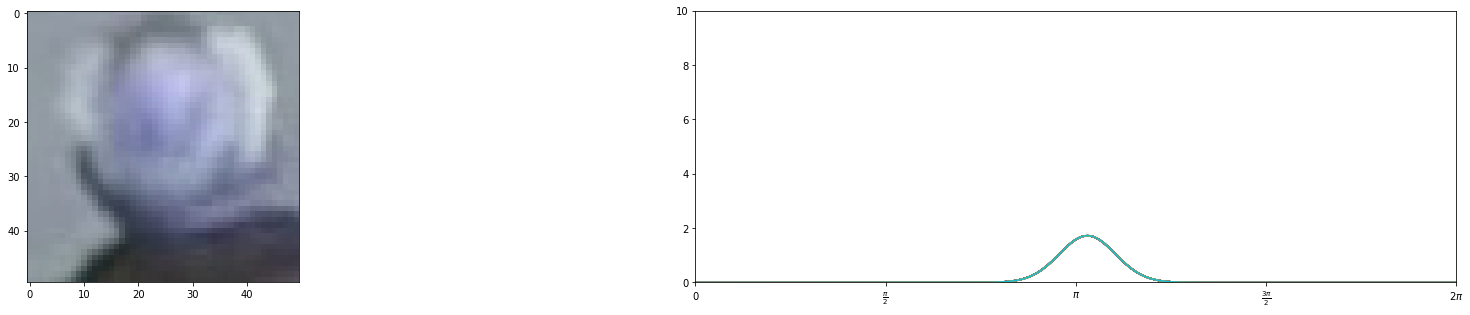

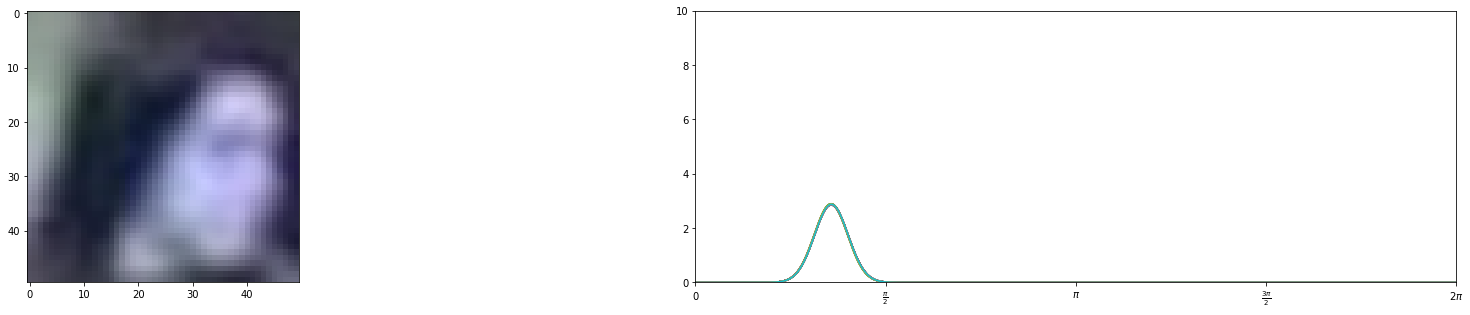

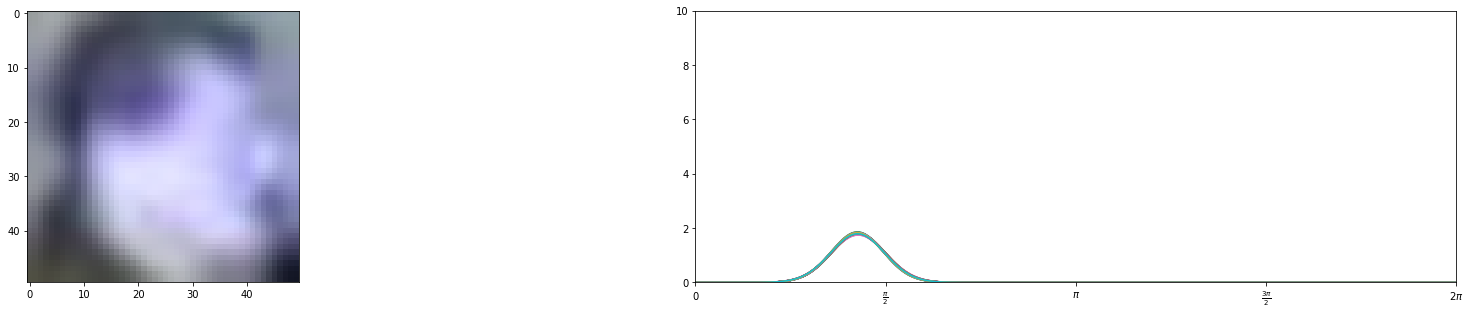

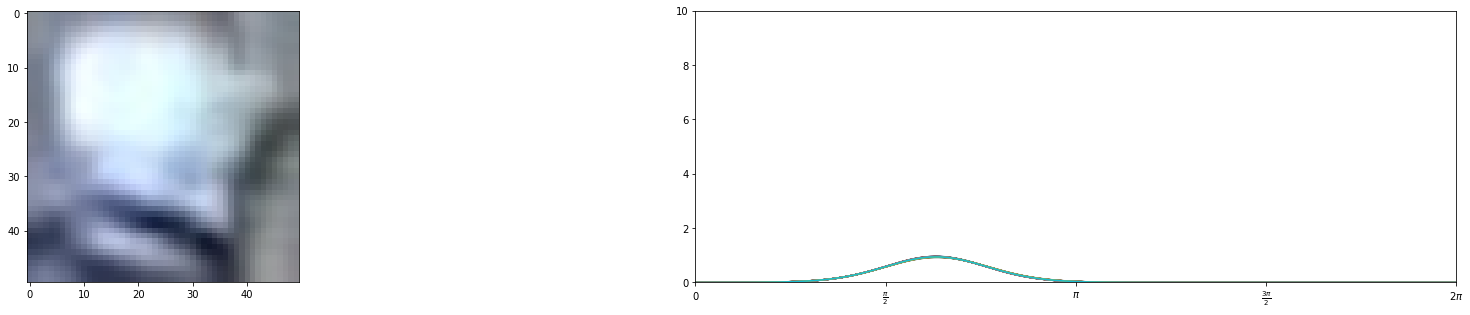

In [63]:
n_samples = 50
n_frames = 20
demo_frames = np.random.randint(0, len(xte), n_frames)
x_demo = xte[demo_frames]

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(x_demo, xvals, n_samples=n_samples)

for fid in range(0, n_frames):
    fig, axs = plt.subplots(1, 2, figsize=(30, 5))
    for sid in range(0, n_samples):
        axs[0].imshow(x_demo[fid])
        plot_pdf(axs[1], xvals, cvae_samples_pdfs[fid, sid,:])
    fig.show()